In [1]:
import rdkit
from rdkit import Chem
import pandas as pd
from rdkit.Chem import RDConfig, rdMolDescriptors, Descriptors, PandasTools
from syba.syba import SybaClassifier
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

root = os.path.dirname(os.getcwd())

## Compute other scores and metrics

In [2]:
def calc_SAscore(mol):
    return sascorer.calculateScore(mol)

scscore_path = os.path.join(root, 'scscore')
sys.path.append(scscore_path)
from scscore.standalone_model_numpy import SCScorer
model_sc = SCScorer()
model_sc.restore(os.path.join(scscore_path, 'models', 'full_reaxys_model_2048bool', 'model.ckpt-10654.as_numpy.pickle'), FP_len=2048)

def calc_SCscore(smi):
    smi, score = model_sc.get_score_from_smi(smi)
    return score

syba = SybaClassifier()
syba.fitDefaultScore()

def calc_SYBA(smi, mol = None):
    # takes very long
    score = syba.predict(smi=smi, mol=mol)
    return score

def calc_logP(mol):
    return rdMolDescriptors.CalcCrippenDescriptors(mol)[0]

def calc_QED(mol):
    return Descriptors.qed(mol)

def calc_MW(mol):
    return Descriptors.MolWt(mol)

def calc_numheavyatoms(mol):
    return mol.GetNumHeavyAtoms()

Restored variables from /home/rebecca/code/intuitive-sc/scscore/models/full_reaxys_model_2048bool/model.ckpt-10654.as_numpy.pickle


In [3]:
# df_graph = pd.read_csv('/home/rebecca/code/intuitive-sc/results/uspto_cjhif_combo_test_reorder_combo_train_graph_sub100000_ep20_2023-07-11_scores.csv')
# df_fp = pd.read_csv('/home/rebecca/code/intuitive-sc/results/uspto_cjhif_combo_test_reorder_combo_train_fp_sub100000_ep20_2023-07-07_scores.csv')
# df_graph.head()
# df_mean_complex = pd.read_csv('/home/rebecca/code/intuitive-sc/data/testsets/sheridan_meancomplexity_clean_scored.csv')
# df_mean_complex.head()
df_fp_chiral = pd.read_csv('/home/rebecca/code/intuitive-sc/data/testsets/df_chiralassign_sub_fpscored_all.csv')
df_fp_chiral.head()

smiles  \
0  CCC[C@](C)(C#N)O[P@@]1(=O)O[C@@H](c2ccccc2)[C@...   
1                           O=Cc1ccc(OC[C@H]2CO2)cc1   
2  Cc1ccnc(-c2ccc(C[C@H](NC(=O)OCc3ccccc3)[C@@H](...   
3  C[Si](C)(C)C#Cc1cn([C@@H]2O[C@H](CO[Si](C)(C)C...   
4  CC(=O)N(Cc1ccccc1)C[C@H]1c2sc(N)c(C(=O)OC(C)(C...   

                                          new_smiles  smiles_score  \
0             CCCC(C)(C#N)OP1(=O)OC(c2ccccc2)C(C)N1C       -1.0690   
1                               O=Cc1ccc(OCC2CO2)cc1        7.7150   
2  Cc1ccnc(-c2ccc(CC(NC(=O)OCc3ccccc3)C(O)CC(Cc3c...       -7.6600   
3  C[Si](C)(C)C#Cc1cn(C2OC(CO[Si](C)(C)C)C(O[Si](...       -0.7783   
4  CC(=O)N(Cc1ccccc1)CC1c2sc(N)c(C(=O)OC(C)(C)C)c...       -9.5860   

   new_smiles_score  smiles_RAscore  new_smiles_RAscore  
0            -7.285        0.411403            0.411403  
1            12.330        0.996068            0.996068  
2            -8.500        0.263926            0.263926  
3            -6.504        0.114263            0.114263  
4           -11.016        0.906283            0.906283

In [4]:
# add mols
# PandasTools.AddMoleculeColumnToFrame(df_graph, smilesCol='smiles_i', molCol='mol_i')
# PandasTools.AddMoleculeColumnToFrame(df_fp, smilesCol='smiles_i', molCol='mol_i')
# PandasTools.AddMoleculeColumnToFrame(df_mean_complex, smilesCol='SMILES', molCol='mol')
PandasTools.AddMoleculeColumnToFrame(df_fp_chiral, smilesCol='smiles', molCol='mol')
PandasTools.AddMoleculeColumnToFrame(df_fp_chiral, smilesCol='new_smiles', molCol='new_mol')

In [5]:
from pathos import multiprocessing as mp
from tqdm import tqdm
import numpy as np

def chunked_parallel(input_list, function, chunks = 1000, max_cpu = 20): 
    """chunked_parallel

    Args:
        input_list : list of objects to apply function
        function : Callable with 1 input and returning a single value
        chunks: number of chunks
        max_cpu: Max num cpus
    """

    cpus = min(mp.cpu_count(), max_cpu)
    pool = mp.Pool(processes = cpus)

    def batch_func(list_inputs): 
        outputs = []
        for i in list_inputs: 
            outputs.append(function(i))
        return outputs

    list_len = len(input_list)
    num_chunks = min(list_len, chunks)
    step_size = len(input_list) // num_chunks

    chunked_list = [input_list[i:i+step_size] 
                    for i in range(0, len(input_list), step_size)]

    list_outputs = list(tqdm(pool.imap(batch_func, chunked_list),
                             total=num_chunks))
    full_output = [j for i in list_outputs for j in i]
    return full_output

In [6]:
def calc_all_scores(df, mol_col = 'mol_i', smiles_col = 'smiles_i'):
    df['SA_score'] = chunked_parallel(df[mol_col], calc_SAscore)
    df['SC_score'] = chunked_parallel(df[smiles_col], calc_SCscore)
    df['SYBA_score'] = chunked_parallel(df[smiles_col], calc_SYBA)
    df['logP'] = chunked_parallel(df[mol_col], calc_logP)
    df['QED'] = chunked_parallel(df[mol_col], calc_QED)
    df['MW'] = chunked_parallel(df[mol_col], calc_MW)
    df['numheavyatoms'] = chunked_parallel(df[mol_col], calc_numheavyatoms)
    return df

In [95]:
df_fp = calc_all_scores(df_fp)
df_fp.head()

KeyError: 'mol_i'

In [ ]:
df_graph = calc_all_scores(df_graph)
df_graph.head()

In [97]:
df_mean_complex = calc_all_scores(df_mean_complex, mol_col = 'mol', smiles_col = 'SMILES')
df_mean_complex.head()

1731it [00:01, 984.74it/s]                          
1731it [00:05, 324.20it/s]                         
1731it [00:01, 1252.60it/s]                         
1731it [00:01, 1291.23it/s]                         
1731it [00:01, 1210.78it/s]                         
1731it [00:01, 1305.64it/s]                         
1731it [00:01, 1294.40it/s]                         


Unnamed: 0 MOLECULE  Source  \
0           0      605  ChEMBL   
1           1     1279  ChEMBL   
2           2     1785  ChEMBL   
3           3     2095  ChEMBL   
4           4     2132  ChEMBL   

                                              SMILES      meanComplexity  \
0                      CN(C)CCCN1c2ccccc2CCc2ccccc12 NaN        1.938462   
1                CC(C)NC[C@@H](O)COc1ccc(CC(=O)N)cc1 NaN        1.650000   
2  C[C@@H](CCc1ccccc1)NC[C@@H](O)c1ccc(O)c(c1)C(=O)N NaN        2.055556   
3                       Nc1ccc(cc1)S(=O)(=O)Nc1nccs1 NaN        1.432432   
4               CCC[C@@H](C)C1(CC=C)C(=O)NC(=S)NC1=O NaN        2.305556   

   stdevComplexity  Votes  SCScore (us)  SAScore (Ertl, in RDKit)  \
0         0.990368     65        3.0930                    1.9331   
1         0.792149     40        3.4710                    2.4358   
2         0.664348     36        3.7772                    2.8086   
3         0.547256     37        2.3133                    2.0317   
4         0.699978     36        2.5216                    3.7121   

                                              ROMol   RAscore  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f83547891c0>  0.988288   
1  <rdkit.Chem.rdchem.Mol object at 0x7f8354789310>  0.993876   
2  <rdkit.Chem.rdchem.Mol object at 0x7f8354789380>  0.995643   
3  <rdkit.Chem.rdchem.Mol object at 0x7f83547893f0>  0.995853   
4  <rdkit.Chem.rdchem.Mol object at 0x7f83547892a0>  0.652913   

                                                mol  SA_score  SC_score  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f81e7dc9ee0>  1.933124  2.967232   
1  <rdkit.Chem.rdchem.Mol object at 0x7f81e7dc9cb0>  2.435829  3.314895   
2  <rdkit.Chem.rdchem.Mol object at 0x7f81e7dc9d20>  2.808567  3.604463   
3  <rdkit.Chem.rdchem.Mol object at 0x7f81e7dc9d90>  2.031708  2.274311   
4  <rdkit.Chem.rdchem.Mol object at 0x7f81e7dc9a10>  3.712117  2.852185   

   SYBA_score    logP       QED       MW  numheavyatoms  
0   50.056017  3.8750  0.838462  280.415             21  
1   90.822667  0.4521  0.637674  266.341             19  
2   95.320077  2.1354  0.596839  328.412             24  
3   86.990906  1.5261  0.814335  255.324             16  
4  -11.788974  1.5160  0.444091  254.355             17

In [98]:
df_mean_complex.drop(columns = ['Unnamed: 0', 'mol', 'SCScore (us)', 'SAScore (Ertl, in RDKit)'], inplace = True)
df_mean_complex.head()

MOLECULE  Source                                             SMILES      \
0      605  ChEMBL                      CN(C)CCCN1c2ccccc2CCc2ccccc12 NaN   
1     1279  ChEMBL                CC(C)NC[C@@H](O)COc1ccc(CC(=O)N)cc1 NaN   
2     1785  ChEMBL  C[C@@H](CCc1ccccc1)NC[C@@H](O)c1ccc(O)c(c1)C(=O)N NaN   
3     2095  ChEMBL                       Nc1ccc(cc1)S(=O)(=O)Nc1nccs1 NaN   
4     2132  ChEMBL               CCC[C@@H](C)C1(CC=C)C(=O)NC(=S)NC1=O NaN   

   meanComplexity  stdevComplexity  Votes  \
0        1.938462         0.990368     65   
1        1.650000         0.792149     40   
2        2.055556         0.664348     36   
3        1.432432         0.547256     37   
4        2.305556         0.699978     36   

                                              ROMol   RAscore  SA_score  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f83547891c0>  0.988288  1.933124   
1  <rdkit.Chem.rdchem.Mol object at 0x7f8354789310>  0.993876  2.435829   
2  <rdkit.Chem.rdchem.Mol object at 0x7f8354789380>  0.995643  2.808567   
3  <rdkit.Chem.rdchem.Mol object at 0x7f83547893f0>  0.995853  2.031708   
4  <rdkit.Chem.rdchem.Mol object at 0x7f83547892a0>  0.652913  3.712117   

   SC_score  SYBA_score    logP       QED       MW  numheavyatoms  
0  2.967232   50.056017  3.8750  0.838462  280.415             21  
1  3.314895   90.822667  0.4521  0.637674  266.341             19  
2  3.604463   95.320077  2.1354  0.596839  328.412             24  
3  2.274311   86.990906  1.5261  0.814335  255.324             16  
4  2.852185  -11.788974  1.5160  0.444091  254.355             17

In [99]:
df_mean_complex.to_csv('/home/rebecca/code/intuitive-sc/data/testsets/sheridan_meancomplexity_clean_scored.csv', index = False)

In [ ]:
df_fp.drop(columns=['mol_i'], inplace=True)
df_fp.to_csv('/home/rebecca/code/intuitive-sc/results/combo_test_fp_sub100000_ep20_2023-07-07_scores_all.csv', index=False)
df_graph.drop(columns=['mol_i'], inplace=True)
df_graph.to_csv('/home/rebecca/code/intuitive-sc/results/combo_test_graph_sub100000_ep20_2023-07-11_scores_all.csv', index=False)

## Analysis

In [7]:
import pandas as pd
import os
from glob import glob

results_folder = '/home/rebecca/code/intuitive-sc/results'
testset = 'sheridan'
# testset = 'syba'
# testset = 'uspto'
if testset == 'sheridan':
        smi_col = 'SMILES'
elif testset == 'syba':
        smi_col = 'smi'
elif testset == 'uspto':
        smi_col = 'smiles_i'
score_col = smi_col + '_score'

csv_files = glob(os.path.join(results_folder, f'*{testset}*best.csv'))
csv_files

['/home/rebecca/code/intuitive-sc/results/sheridan_meancomplexity_clean_scored_fp_morgan_count_chiral_ep25x10_2023-08-22_best.csv',
 '/home/rebecca/code/intuitive-sc/results/sheridan_meancomplexity_clean_scored_graph_GGG_ep25x10_2023-08-30_best.csv',
 '/home/rebecca/code/intuitive-sc/results/sheridan_meancomplexity_clean_scored_fp_morgan_count_ep25x10_2023-08-21_best.csv',
 '/home/rebecca/code/intuitive-sc/results/sheridan_meancomplexity_clean_scored_fp_morgan_ep25x10_2023-08-22_best.csv',
 '/home/rebecca/code/intuitive-sc/results/sheridan_meancomplexity_clean_scored_graph_ep25x10_2023-08-25_best.csv',
 '/home/rebecca/code/intuitive-sc/results/sheridan_meancomplexity_clean_scored_fp_morgan_chiral_ep25x10_2023-08-22_best.csv']

In [8]:
df_graph = pd.read_csv(csv_files[4], index_col = 0)
df_fp = pd.read_csv(csv_files[2], index_col = 0)

In [9]:
# deduplicate for analysis
df_fp = df_fp.drop_duplicates(subset=[smi_col])
df_graph = df_graph.drop_duplicates(subset=[smi_col])
# df_fp = df_fp[df_fp['source'] == 'MC']
# df_graph = df_graph[df_graph['source'] == 'MC']
# df_fp = df_fp[df_fp['source'] == 'CP']
# df_graph = df_graph[df_graph['source'] == 'CP']
df_fp.reset_index(inplace=True)
df_graph.reset_index(inplace=True)

In [10]:
df_graph.head()

MOLECULE  Source                                             SMILES      \
0      605  ChEMBL                      CN(C)CCCN1c2ccccc2CCc2ccccc12 NaN   
1     1279  ChEMBL                CC(C)NC[C@@H](O)COc1ccc(CC(=O)N)cc1 NaN   
2     1785  ChEMBL  C[C@@H](CCc1ccccc1)NC[C@@H](O)c1ccc(O)c(c1)C(=O)N NaN   
3     2095  ChEMBL                       Nc1ccc(cc1)S(=O)(=O)Nc1nccs1 NaN   
4     2132  ChEMBL               CCC[C@@H](C)C1(CC=C)C(=O)NC(=S)NC1=O NaN   

   meanComplexity  stdevComplexity  Votes  \
0        1.938462         0.990368     65   
1        1.650000         0.792149     40   
2        2.055556         0.664348     36   
3        1.432432         0.547256     37   
4        2.305556         0.699978     36   

                                              ROMol   RAscore  SA_score  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f83547891c0>  0.988288  1.933124   
1  <rdkit.Chem.rdchem.Mol object at 0x7f8354789310>  0.993876  2.435829   
2  <rdkit.Chem.rdchem.Mol object at 0x7f8354789380>  0.995643  2.808567   
3  <rdkit.Chem.rdchem.Mol object at 0x7f83547893f0>  0.995853  2.031708   
4  <rdkit.Chem.rdchem.Mol object at 0x7f83547892a0>  0.652913  3.712117   

   SC_score  SYBA_score    logP       QED       MW  numheavyatoms  \
0  2.967232   50.056017  3.8750  0.838462  280.415             21   
1  3.314895   90.822667  0.4521  0.637674  266.341             19   
2  3.604463   95.320077  2.1354  0.596839  328.412             24   
3  2.274311   86.990906  1.5261  0.814335  255.324             16   
4  2.852185  -11.788974  1.5160  0.444091  254.355             17   

   SMILES_score  
0        -3.686  
1        -5.040  
2        -7.684  
3         1.186  
4        -1.087

### Plot correlations

In [11]:
from scipy.stats import pearsonr

def plot_scatter(ax, x_fp = None, y_fp = None, x_graph = None, y_graph = None, xlabel ='ours', ylabel='old score'):
    if x_fp is not None and y_fp is not None:
        pcc_fp = pearsonr(x_fp, y_fp)[0]
        ax.scatter(x_fp, y_fp, alpha = 0.3, label = f'FP (PCC={pcc_fp:.3f})', s=2);
    else:
        pcc_fp = None
    if x_graph is not None and y_graph is not None:
        pcc_graph = pearsonr(x_graph, y_graph)[0]
        ax.scatter(x_graph, y_graph, alpha = 0.3, label = f'Graph (PCC={pcc_graph:.3f})', s=2);
    else:
        pcc_graph = None
    ax.set_xlabel(xlabel);
    ax.set_ylabel(ylabel);
    ax.legend(loc='lower left');
    ax.set_title(ylabel);
    return pcc_fp, pcc_graph

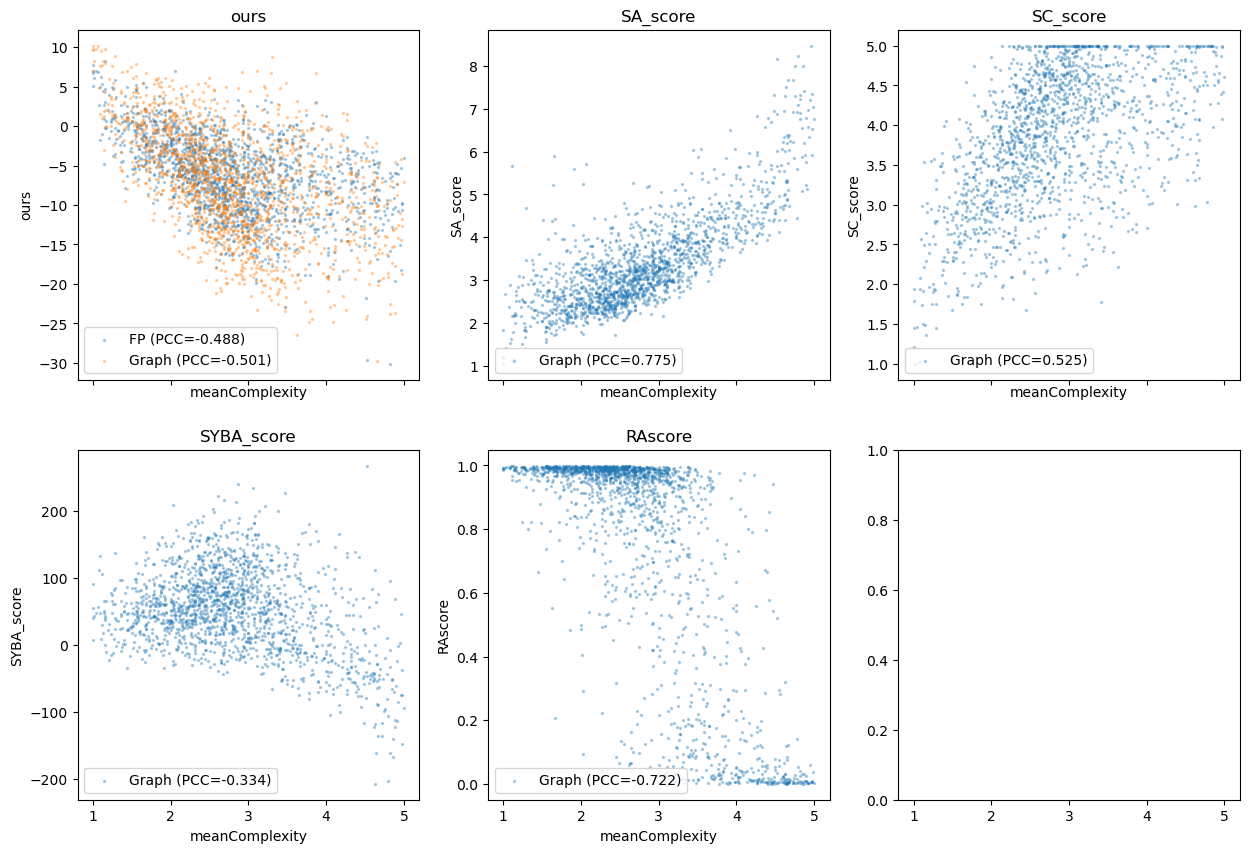

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,3,figsize=(15, 10), sharex=True)

pcc_fp_new_mc, pcc_graph_new_mc = plot_scatter(axs[0,0], x_fp=df_fp['meanComplexity'], y_fp=df_fp[score_col], y_graph = df_graph[score_col], x_graph=df_graph['meanComplexity'], xlabel = 'meanComplexity', ylabel = 'ours')
pcc_fp_sa_mc, pcc_graph_sa_mc = plot_scatter(axs[0,1], y_graph = df_graph['SA_score'], x_graph=df_graph['meanComplexity'], xlabel = 'meanComplexity', ylabel = 'SA_score')
pcc_fp_sc_mc, pcc_graph_sc_mc = plot_scatter(axs[0,2], y_graph = df_graph['SC_score'], x_graph=df_graph['meanComplexity'], xlabel = 'meanComplexity', ylabel = 'SC_score')
pcc_fp_syba_mc, pcc_graph_syba_mc = plot_scatter(axs[1,0], y_graph = df_graph['SYBA_score'], x_graph=df_graph['meanComplexity'], xlabel = 'meanComplexity', ylabel = 'SYBA_score')
pcc_fp_ra_mc, pcc_graph_ra_mc = plot_scatter(axs[1,1], y_graph = df_graph['RAscore'], x_graph=df_graph['meanComplexity'], xlabel = 'meanComplexity', ylabel = 'RAscore')



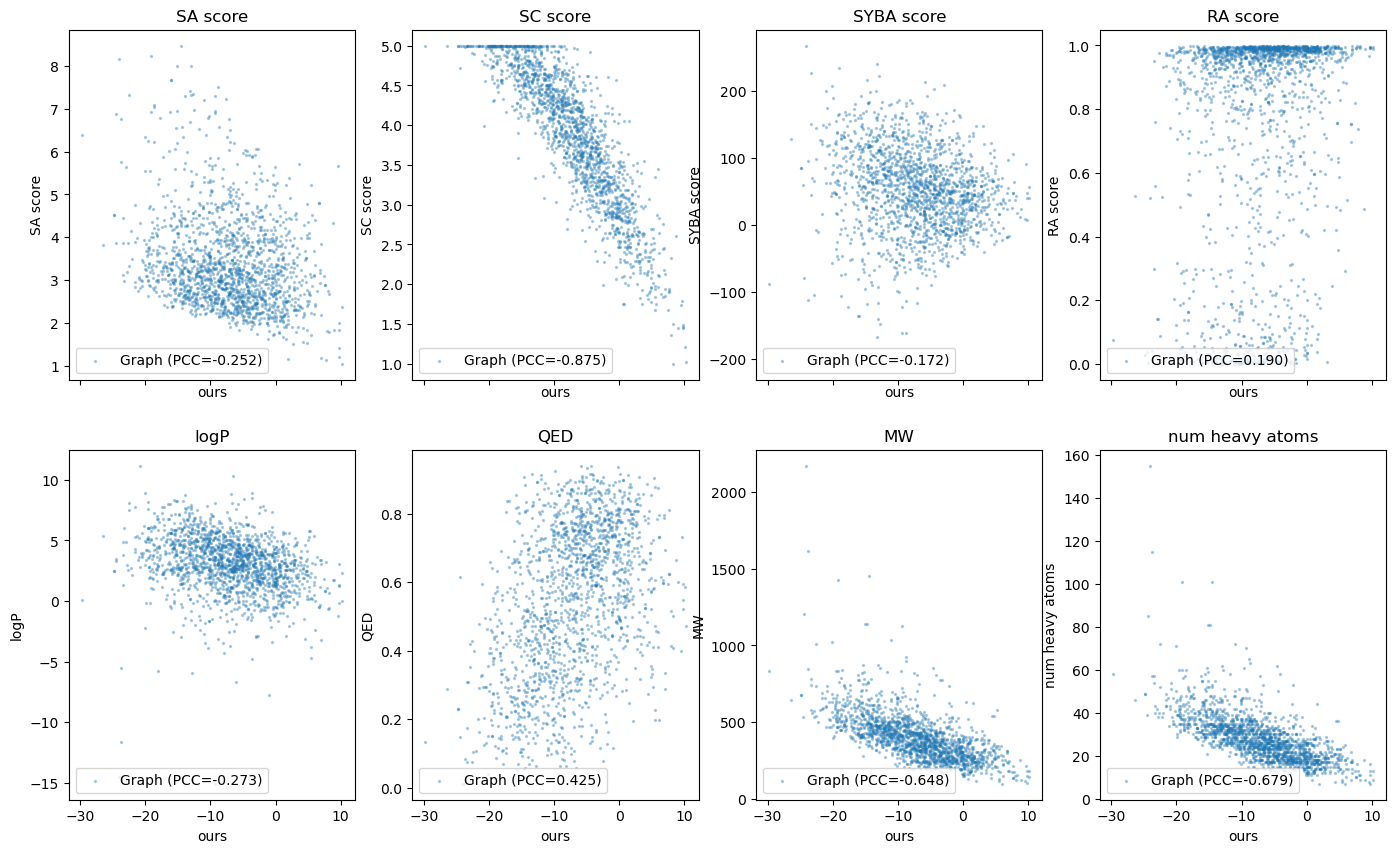

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,4,figsize=(17, 10), sharex=True)

pcc_fp_new_sa, pcc_graph_new_sa = plot_scatter(axs[0,0], x_graph = df_graph[score_col], y_graph=df_graph['SA_score'], ylabel = 'SA score')
pcc_fp_new_sc, pcc_graph_new_sc = plot_scatter(axs[0,1], x_graph = df_graph[score_col], y_graph=df_graph['SC_score'], ylabel = 'SC score')
pcc_fp_new_syba, pcc_graph_new_syba = plot_scatter(axs[0,2], x_graph = df_graph[score_col], y_graph=df_graph['SYBA_score'], ylabel = 'SYBA score')
pcc_fp_new_ra, pcc_graph_new_ra = plot_scatter(axs[0,3], x_graph = df_graph[score_col], y_graph=df_graph['RAscore'], ylabel = 'RA score')
pcc_fp_new_logp, pcc_graph_new_logp = plot_scatter(axs[1,0], x_graph = df_graph[score_col], y_graph=df_graph['logP'], ylabel = 'logP')
pcc_fp_new_qed, pcc_graph_new_qed = plot_scatter(axs[1,1], x_graph = df_graph[score_col], y_graph=df_graph['QED'], ylabel = 'QED')
pcc_fp_new_mw, pcc_graph_new_mw = plot_scatter(axs[1,2], x_graph = df_graph[score_col], y_graph=df_graph['MW'], ylabel = 'MW')
pcc_fp_new_natoms, pcc_graph_new_natoms = plot_scatter(axs[1,3], x_graph = df_graph[score_col], y_graph=df_graph['numheavyatoms'], ylabel = 'num heavy atoms')

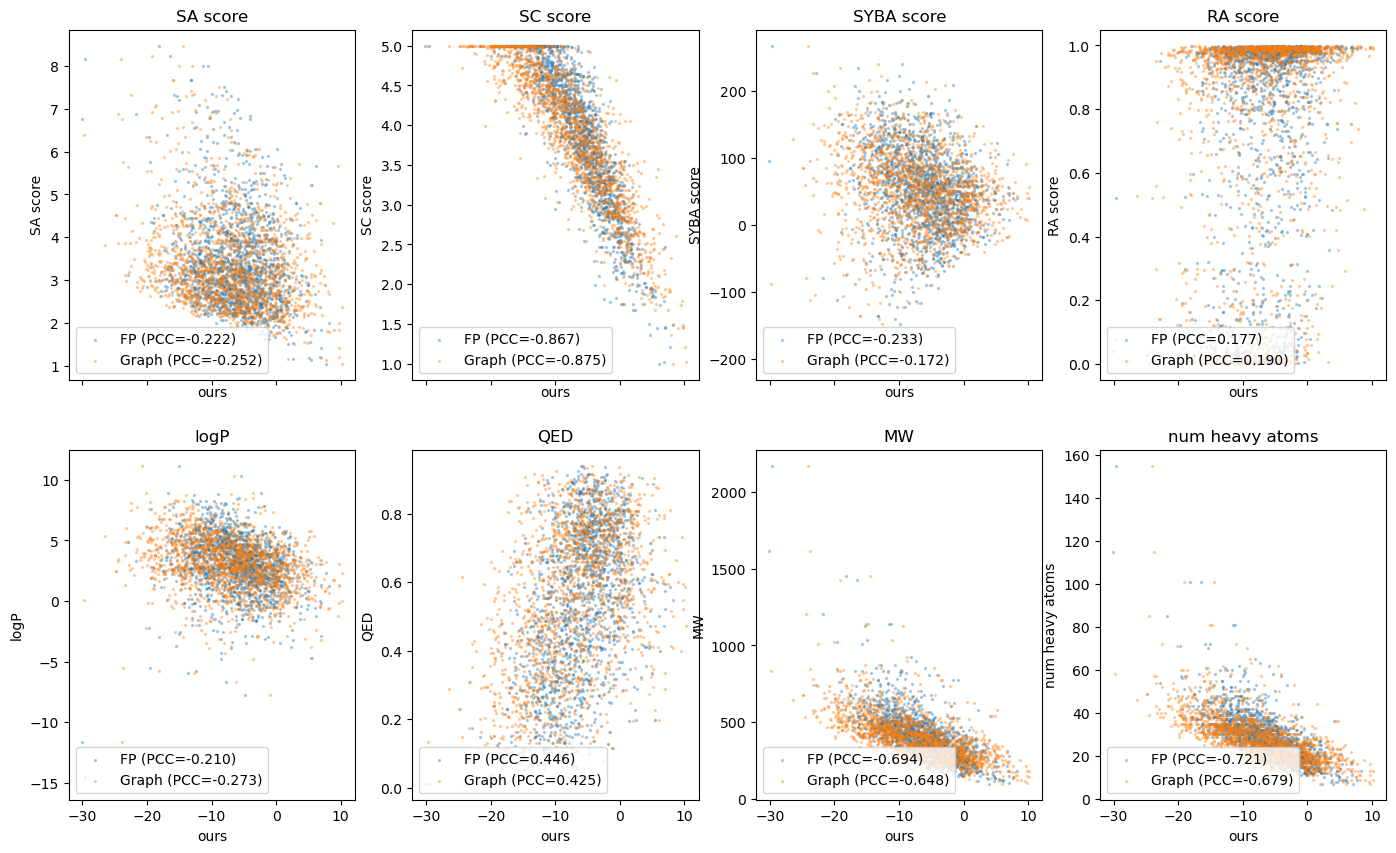

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,4,figsize=(17, 10), sharex=True)

pcc_fp_new_sa, pcc_graph_new_sa = plot_scatter(axs[0,0], df_fp[score_col], df_fp['SA_score'], df_graph[score_col], df_graph['SA_score'], ylabel='SA score', xlabel='ours')
pcc_fp_new_sc, pcc_graph_new_sc = plot_scatter(axs[0,1], df_fp[score_col], df_fp['SC_score'], df_graph[score_col], df_graph['SC_score'], ylabel='SC score', xlabel='ours')
pcc_fp_new_syba, pcc_graph_new_syba = plot_scatter(axs[0,2], df_fp[score_col], df_fp['SYBA_score'], df_graph[score_col], df_graph['SYBA_score'], ylabel='SYBA score', xlabel='ours')
pcc_fp_new_ra, pcc_graph_new_ra = plot_scatter(axs[0,3], df_fp[score_col], df_fp['RAscore'], df_graph[score_col], df_graph['RAscore'], ylabel='RA score', xlabel='ours')
pcc_fp_new_logp, pcc_graph_new_logp = plot_scatter(axs[1,0], df_fp[score_col], df_fp['logP'], df_graph[score_col], df_graph['logP'], ylabel='logP', xlabel='ours')
pcc_fp_new_qed, pcc_graph_new_qed = plot_scatter(axs[1,1], df_fp[score_col], df_fp['QED'], df_graph[score_col], df_graph['QED'], ylabel='QED', xlabel='ours')
pcc_fp_new_mw, pcc_graph_new_mw = plot_scatter(axs[1,2], df_fp[score_col], df_fp['MW'], df_graph[score_col], df_graph['MW'], ylabel='MW', xlabel='ours')
pcc_fp_new_natoms, pcc_graph_new_natoms = plot_scatter(axs[1,3], df_fp[score_col], df_fp['numheavyatoms'], df_graph[score_col], df_graph['numheavyatoms'], ylabel='num heavy atoms', xlabel='ours')

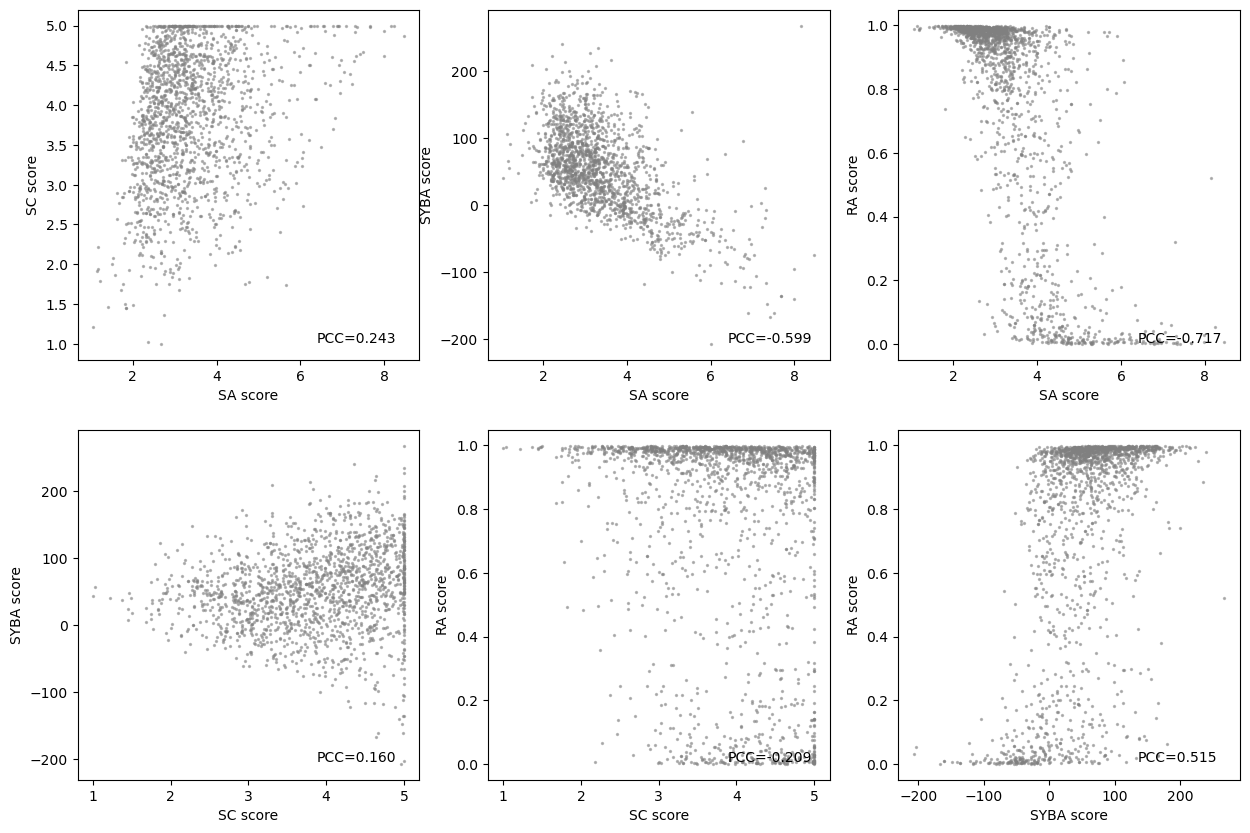

In [15]:
# correlations between old scores themselves

fig, axs = plt.subplots(2,3,figsize=(15, 10))

pccsa_sc = pearsonr(df_fp['SA_score'], df_fp['SC_score'])[0]
pccsa_syba = pearsonr(df_fp['SA_score'], df_fp['SYBA_score'])[0]
pccsa_ra = pearsonr(df_fp['SA_score'], df_fp['RAscore'])[0]
axs[0,0].scatter(df_fp['SA_score'], df_fp['SC_score'], alpha = 0.5, label = f'PCC={pccsa_sc:.3f}', s=2, color='grey');
axs[0,0].set_xlabel('SA score');
axs[0,0].set_ylabel('SC score');
axs[0,0].text(0.7, 0.05, f'PCC={pccsa_sc:.3f}', transform=axs[0,0].transAxes)

axs[0,1].scatter(df_fp['SA_score'], df_fp['SYBA_score'], alpha = 0.5, label = f'PCC={pccsa_syba:.3f}', s=2, color='grey');
axs[0,1].set_xlabel('SA score');
axs[0,1].set_ylabel('SYBA score');
axs[0,1].text(0.7, 0.05, f'PCC={pccsa_syba:.3f}', transform=axs[0,1].transAxes)

axs[0,2].scatter(df_fp['SA_score'], df_fp['RAscore'], alpha = 0.5, label = f'PCC={pccsa_ra:.3f}', s=2, color='grey');
axs[0,2].set_xlabel('SA score');
axs[0,2].set_ylabel('RA score');
axs[0,2].text(0.7, 0.05, f'PCC={pccsa_ra:.3f}', transform=axs[0,2].transAxes)

pccsc_syba = pearsonr(df_fp['SC_score'], df_fp['SYBA_score'])[0]
pccsc_ra = pearsonr(df_fp['SC_score'], df_fp['RAscore'])[0]
axs[1,0].scatter(df_fp['SC_score'], df_fp['SYBA_score'], alpha = 0.5, label = f'PCC={pccsc_syba:.3f}', s=2, color='grey');
axs[1,0].set_xlabel('SC score');
axs[1,0].set_ylabel('SYBA score');
axs[1,0].text(0.7, 0.05, f'PCC={pccsc_syba:.3f}', transform=axs[1,0].transAxes)

axs[1,1].scatter(df_fp['SC_score'], df_fp['RAscore'], alpha = 0.5, label = f'PCC={pccsc_ra:.3f}', s=2, color='grey');
axs[1,1].set_xlabel('SC score');
axs[1,1].set_ylabel('RA score');
axs[1,1].text(0.7, 0.05, f'PCC={pccsc_ra:.3f}', transform=axs[1,1].transAxes)

pccsyba_ra = pearsonr(df_fp['SYBA_score'], df_fp['RAscore'])[0]
axs[1,2].scatter(df_fp['SYBA_score'], df_fp['RAscore'], alpha = 0.5, label = f'PCC={pccsyba_ra:.3f}', s=2, color='grey');
axs[1,2].set_xlabel('SYBA score');
axs[1,2].set_ylabel('RA score');
axs[1,2].text(0.7, 0.05, f'PCC={pccsyba_ra:.3f}', transform=axs[1,2].transAxes);

In [17]:
# pcc between graph and fp scores
pcc_graph_fp = pearsonr(df_graph[score_col], df_fp[score_col])[0]
pcc_graph_fp

0.9107836466538631

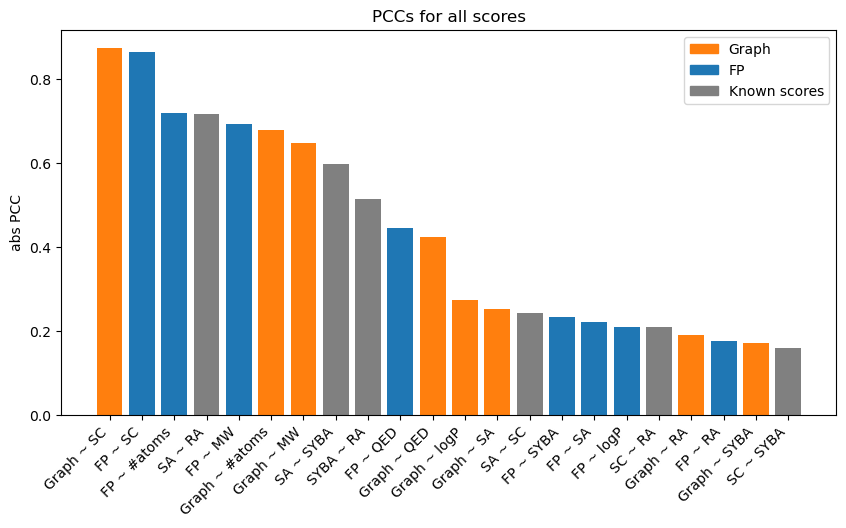

In [173]:
# barplots of correlations
import matplotlib.patches as mpatches
pccs_fp = [pcc_fp_new_sa, pcc_fp_new_sc, pcc_fp_new_syba, pcc_fp_new_ra, pcc_fp_new_logp, pcc_fp_new_qed, pcc_fp_new_mw, pcc_fp_new_natoms]
pccs_graph = [pcc_graph_new_sa, pcc_graph_new_sc, pcc_graph_new_syba, pcc_graph_new_ra, pcc_graph_new_logp, pcc_graph_new_qed, pcc_graph_new_mw, pcc_graph_new_natoms]
pccs_old = [pccsa_sc, pccsa_syba, pccsa_ra, pccsc_syba, pccsc_ra, pccsyba_ra]

ppcs_all = pccs_fp + pccs_graph + pccs_old

# color list based on fp, graph, old
colors = ['tab:blue']*8 + ['tab:orange']*8 + ['grey']*6

# legends
legends = ['FP ~ SA', 'FP ~ SC', 'FP ~ SYBA', 'FP ~ RA', 'FP ~ logP', 'FP ~ QED', 'FP ~ MW', 'FP ~ #atoms', 'Graph ~ SA', 'Graph ~ SC', 'Graph ~ SYBA', 'Graph ~ RA', 'Graph ~ logP', 'Graph ~ QED', 'Graph ~ MW', 'Graph ~ #atoms', 'SA ~ SC', 'SA ~ SYBA', 'SA ~ RA', 'SC ~ SYBA', 'SC ~ RA', 'SYBA ~ RA']

# get absolute values
ppcs_all = [abs(x) for x in ppcs_all]

# make dictionary with colors
color_dict = dict(zip(ppcs_all, colors))
legends_dict = dict(zip(ppcs_all, legends))

# sort by descending order
ppcs_all.sort(reverse=True)

# get colors and legends in same order
colors_sorted = [color_dict[x] for x in ppcs_all]
legends_sorted = [legends_dict[x] for x in ppcs_all]

# plot absolute values
plt.figure(figsize=(10,5));
plt.bar(range(len(ppcs_all)), ppcs_all, color=colors_sorted);
plt.xticks(range(len(ppcs_all)), legends_sorted, rotation=45, ha='right');
plt.ylabel('abs PCC');
plt.title('PCCs for all scores');

graph_patch = mpatches.Patch(color='tab:orange', label='Graph');
fp_patch = mpatches.Patch(color='tab:blue', label='FP');
old_patch = mpatches.Patch(color='grey', label='Known scores');
plt.legend(handles=[graph_patch, fp_patch, old_patch]);


### Visualize examples

In [174]:
# display top and bottom 10 molecules with their scores
df_fp.sort_values(by=[score_col], inplace=True)
df_graph.sort_values(by=[score_col], inplace=True)

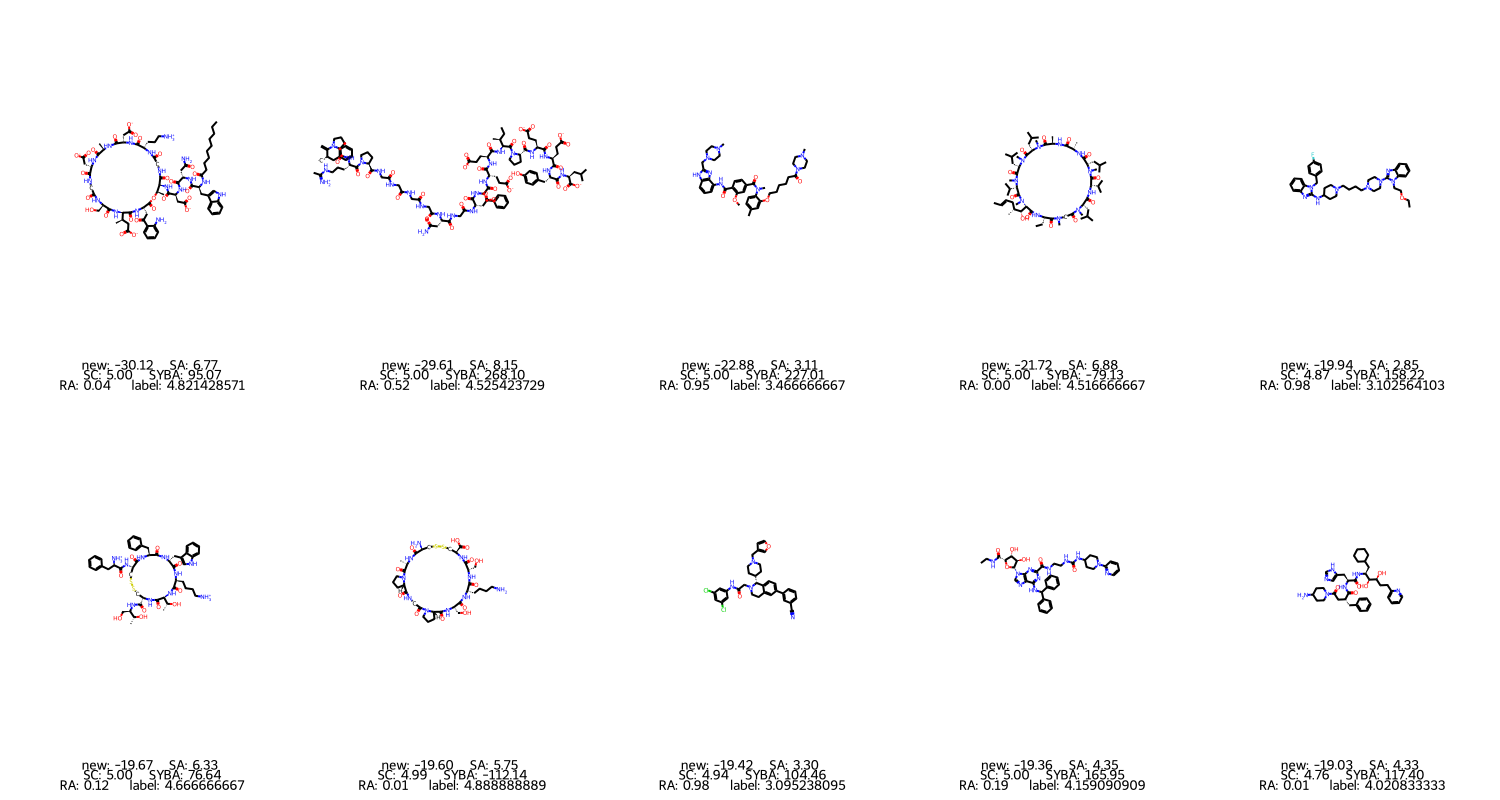

In [202]:
from rdkit import Chem
from rdkit.Chem import Draw
n = 10
bottom_smi = df_fp[smi_col].head(n).tolist()
bottom_mols = [Chem.MolFromSmiles(smi) for smi in bottom_smi]
bottom_scores = df_fp[score_col].head(n).tolist()
bottom_sa = df_fp['SA_score'].head(n).tolist()
bottom_sc = df_fp['SC_score'].head(n).tolist()
bottom_syba = df_fp['SYBA_score'].head(n).tolist()
bottom_ra = df_fp['RAscore'].head(n).tolist()
if testset == 'syba':
    bottom_label = df_fp['label'].head(10).tolist()
elif testset == 'sheridan':
    bottom_label = df_fp['meanComplexity'].head(10).tolist()
else:
    bottom_label = ['']*10
# create legend texts for every mol by zipping the scores together
legends = [f'new: {new:.2f}\t SA: {sa:.2f}\n SC: {sc:.2f}\t SYBA: {syba:.2f}\n RA: {ra:.2f} \t label: {label}' for new, sa, sc, syba, ra, label in zip(bottom_scores, bottom_sa, bottom_sc, bottom_syba, bottom_ra, bottom_label)]
Chem.Draw.MolsToGridImage(bottom_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

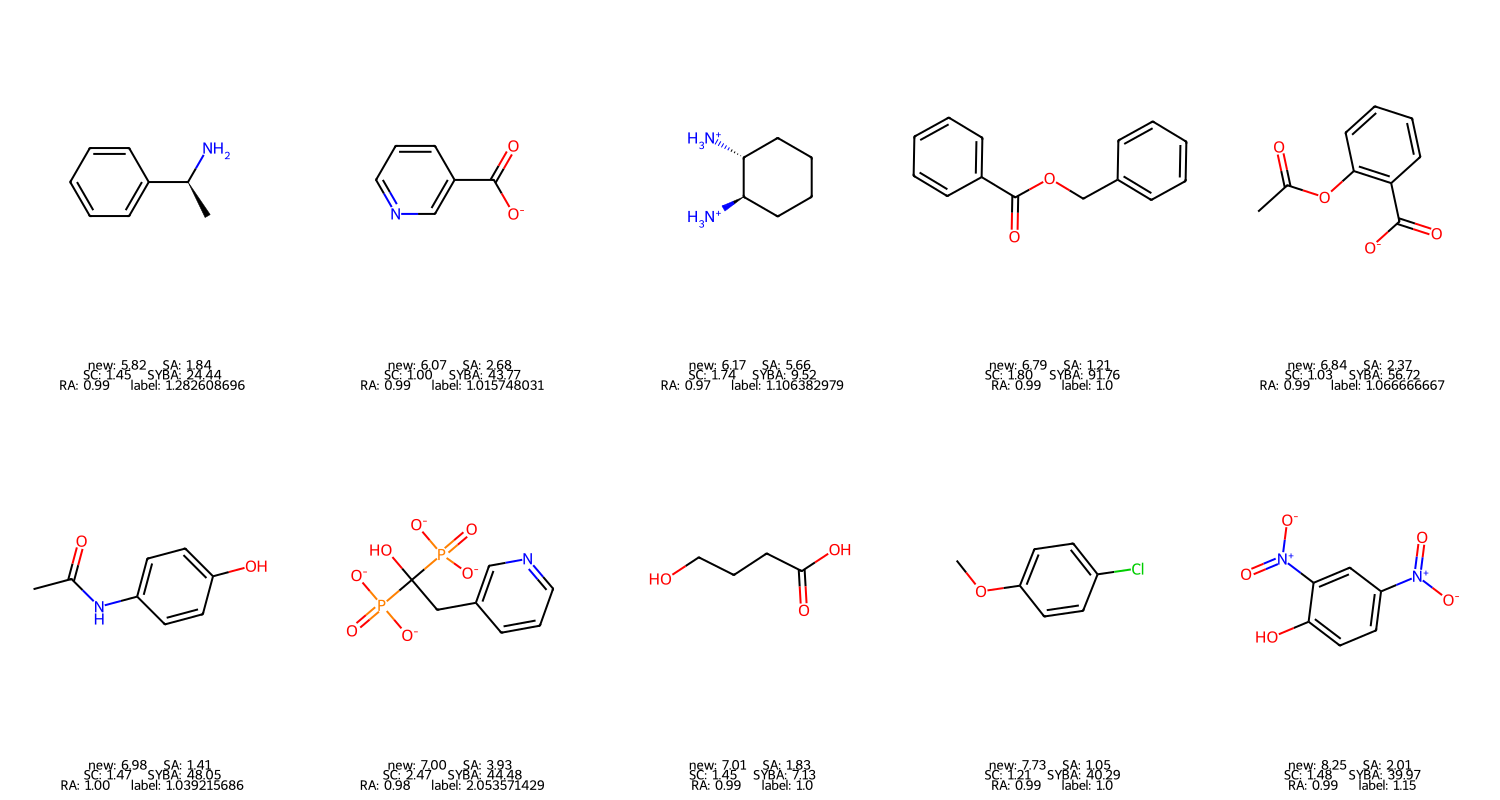

In [203]:
top_smi = df_fp[smi_col].tail(10).tolist()
top_mols = [Chem.MolFromSmiles(smi) for smi in top_smi]
top_scores = df_fp[score_col].tail(10).tolist()
top_sa = df_fp['SA_score'].tail(10).tolist()
top_sc = df_fp['SC_score'].tail(10).tolist()
top_syba = df_fp['SYBA_score'].tail(10).tolist()
top_ra = df_fp['RAscore'].tail(10).tolist()
if testset == 'syba':
    top_label = df_fp['label'].tail(10).tolist()
elif testset == 'sheridan':
    top_label = df_fp['meanComplexity'].tail(10).tolist()
else:
    top_label = ['']*10
# create legend texts for every mol by zipping the scores together
legends = [f'new: {new:.2f}\t SA: {sa:.2f}\n SC: {sc:.2f}\t SYBA: {syba:.2f}\n RA: {ra:.2f} \t label: {label}' for new, sa, sc, syba, ra, label in zip(top_scores, top_sa, top_sc, top_syba, top_ra, top_label)]
Chem.Draw.MolsToGridImage(top_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

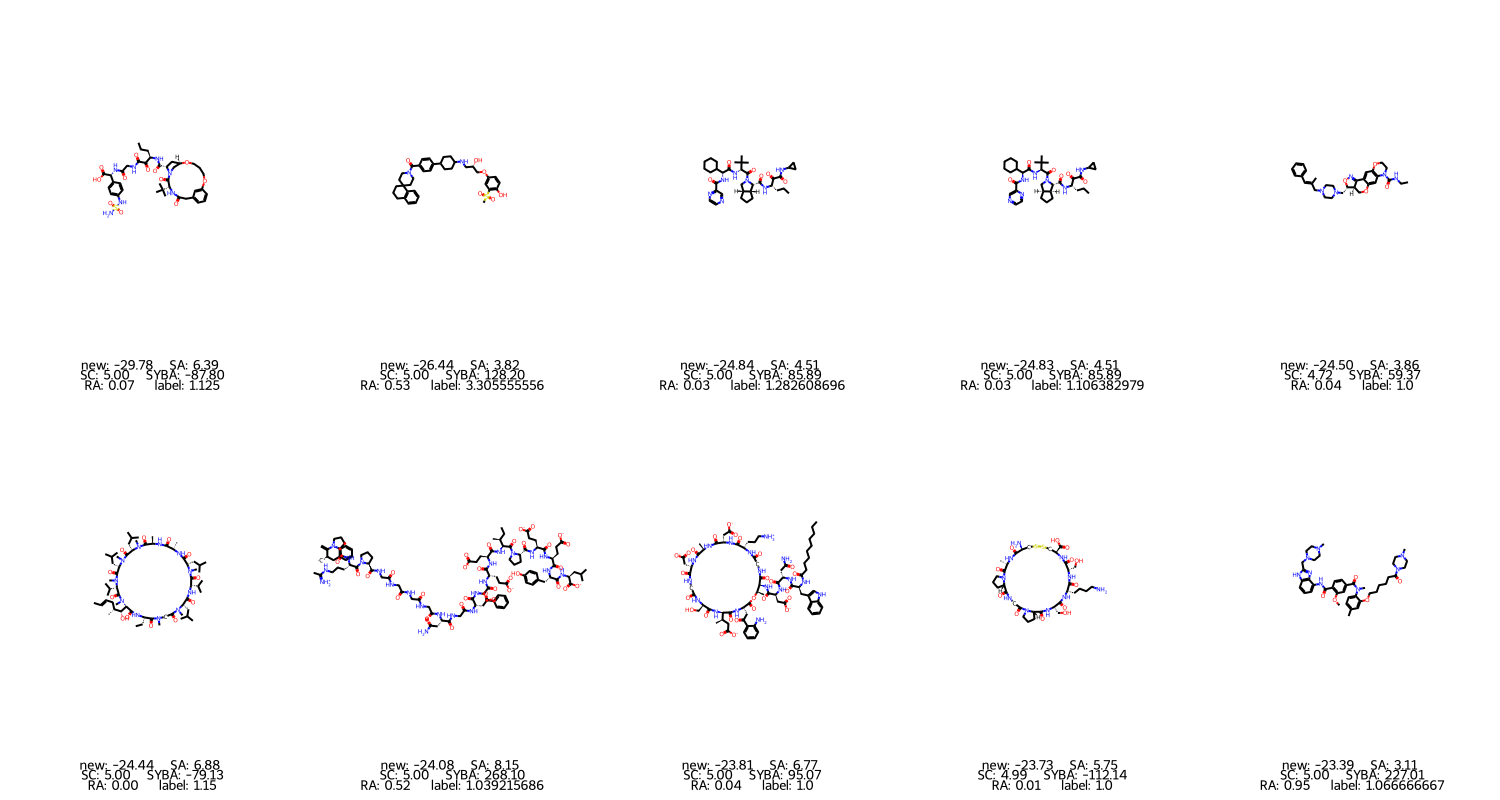

In [204]:
bottom_smi = df_graph[smi_col].head(n).tolist()
bottom_mols = [Chem.MolFromSmiles(smi) for smi in bottom_smi]
bottom_scores = df_graph[score_col].head(n).tolist()
bottom_sa = df_graph['SA_score'].head(n).tolist()
bottom_sc = df_graph['SC_score'].head(n).tolist()
bottom_syba = df_graph['SYBA_score'].head(n).tolist()
bottom_ra = df_graph['RAscore'].head(n).tolist()
if testset == 'syba':
    bottom_label = df_graph['label'].tail(10).tolist()
elif testset == 'sheridan':
    bottom_label = df_graph['meanComplexity'].tail(10).tolist()
else:
    bottom_label = ['']*10
# create legend texts for every mol by zipping the scores together
legends = [f'new: {new:.2f}\t SA: {sa:.2f}\n SC: {sc:.2f}\t SYBA: {syba:.2f}\n RA: {ra:.2f} \t label: {label}' for new, sa, sc, syba, ra, label in zip(bottom_scores, bottom_sa, bottom_sc, bottom_syba, bottom_ra, bottom_label)]
Chem.Draw.MolsToGridImage(bottom_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

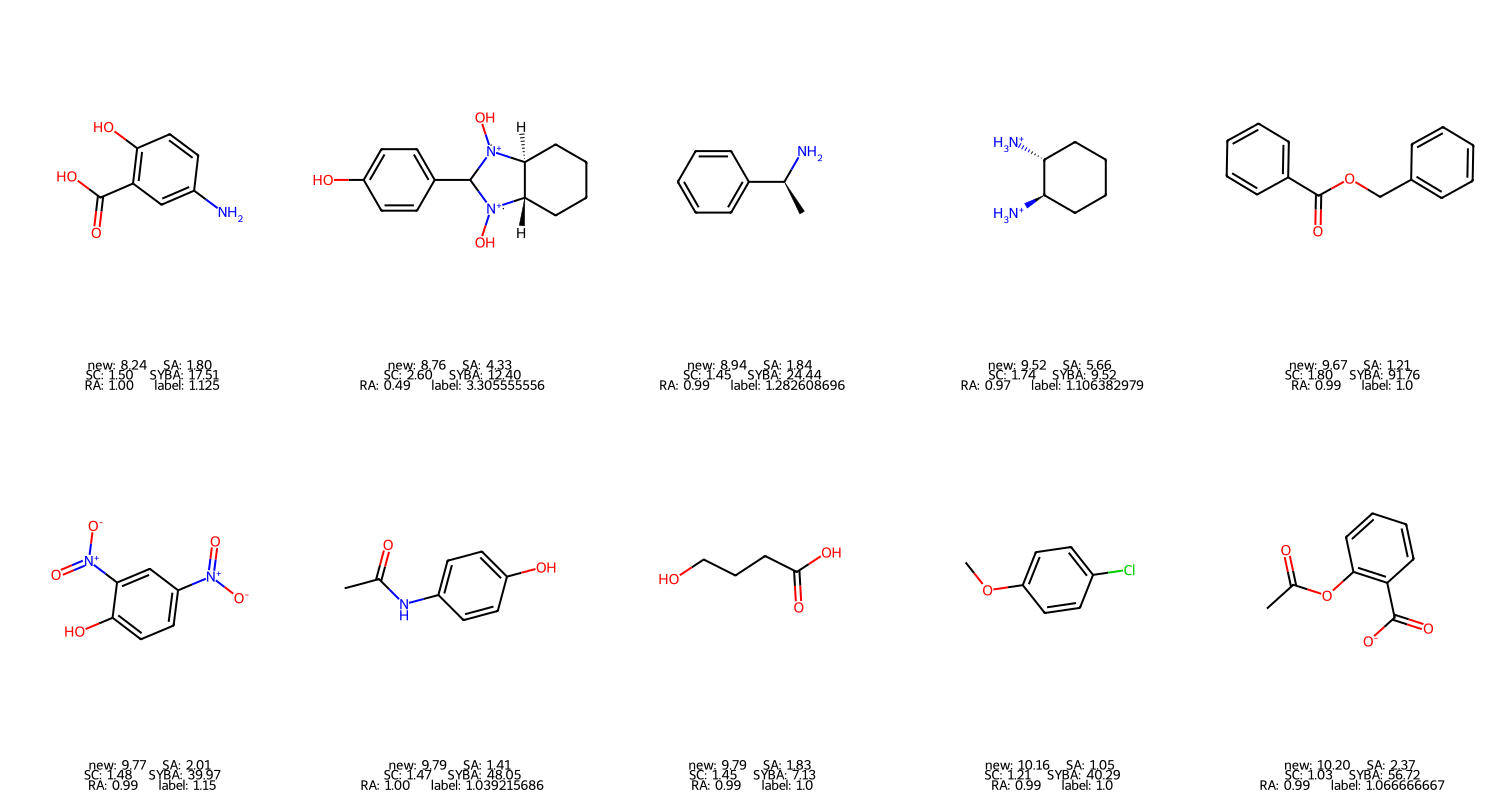

In [205]:
top_smi = df_graph[smi_col].tail(10).tolist()
top_mols = [Chem.MolFromSmiles(smi) for smi in top_smi]
top_scores = df_graph[score_col].tail(10).tolist()
top_sa = df_graph['SA_score'].tail(10).tolist()
top_sc = df_graph['SC_score'].tail(10).tolist()
top_syba = df_graph['SYBA_score'].tail(10).tolist()
top_ra = df_graph['RAscore'].tail(10).tolist()
if testset == 'syba':
    top_label = df_graph['label'].tail(10).tolist()
elif testset == 'sheridan':
    top_label = df_graph['meanComplexity'].tail(10).tolist()
else:
    top_label = ['']*10
# create legend texts for every mol by zipping the scores together
legends = [f'new: {new:.2f}\t SA: {sa:.2f}\n SC: {sc:.2f}\t SYBA: {syba:.2f}\n RA: {ra:.2f} \t label: {label}' for new, sa, sc, syba, ra, label in zip(top_scores, top_sa, top_sc, top_syba, top_ra, top_label)]
Chem.Draw.MolsToGridImage(top_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

In [195]:
# visualize those where the difference is the largest between FP and graph
df_combo = pd.merge(df_fp, df_graph, on=smi_col, suffixes=('_fp', '_graph'))
if testset == 'syba':
    extra_label = 'label_graph'
elif testset == 'sheridan':
    extra_label = 'meanComplexity_graph'
elif testset == 'uspto':
    extra_label = 'label_graph'
df_combo = df_combo[[smi_col, f'{score_col}_fp', f'{score_col}_graph', extra_label]]
# drop columns that are not needed
df_combo['diff'] = df_combo[f'{score_col}_fp'] - df_combo[f'{score_col}_graph']
# absolute value
df_combo['abs_diff'] = df_combo['diff'].abs()
df_combo.head()

SMILES  SMILES_score_fp  \
0  c12ccccc2[nH]cc1C[C@@H](C(N[C@@H](CC(N)=O)C(N[...           -30.12   
1  N1(CCC[C@H]1C(N[C@@H](CCC([O-])=O)C(N[C@@H](CC...           -29.61   
2  c12c([nH]c(n2)CN2CCN(C)CC2)cccc1NC(c1c(cc(C(N(...           -22.88   
3  N1(C)[C@@H]([C@@H]([C@H](C)C\C=C\C)O)C(N[C@H](...           -21.72   
4  c1(n(c2ccccc2n1)CCOCC)N1CCN(CCCCN2CCC(Nc3n(c4c...           -19.94   

   SMILES_score_graph  meanComplexity_graph  diff  abs_diff  
0              -23.81              4.821429 -6.31      6.31  
1              -24.08              4.525424 -5.53      5.53  
2              -23.39              3.466667  0.51      0.51  
3              -24.44              4.516667  2.72      2.72  
4              -18.47              3.102564 -1.47      1.47

In [196]:
# sort by descending order
df_combo.sort_values(by=['abs_diff'], inplace=True, ascending=False)
df_combo.head()

SMILES  SMILES_score_fp  \
28   CCC[C@@H](NC(=O)[C@@H]1C[C@@H]2CN1C(=O)[C@@H](...           -16.83   
578  C12(c3c(ccc(c3)NC(c3ccc(C(c4ccc(C)cc4)=O)cc3)=...            -8.08   
170  c12C=3[C@H]([C@H](CN4CCN(C\C(=C\c5ccccc5)C)CC4...           -12.58   
281  c12OCCCCOc3cc(C[C@@H]([C@@H](CNC4(CC4)c4cc(ccc...           -11.09   
207  c1ccccc1c1cccc2c1nc([nH]2)[C@H]1N2[C@H](CC1)CC...           -12.02   

     SMILES_score_graph  meanComplexity_graph   diff  abs_diff  
28               -29.78              4.651163  12.95     12.95  
578              -20.56              2.638889  12.48     12.48  
170              -24.50              3.820513  11.92     11.92  
281              -22.95              4.051282  11.86     11.86  
207              -23.36              4.255814  11.34     11.34

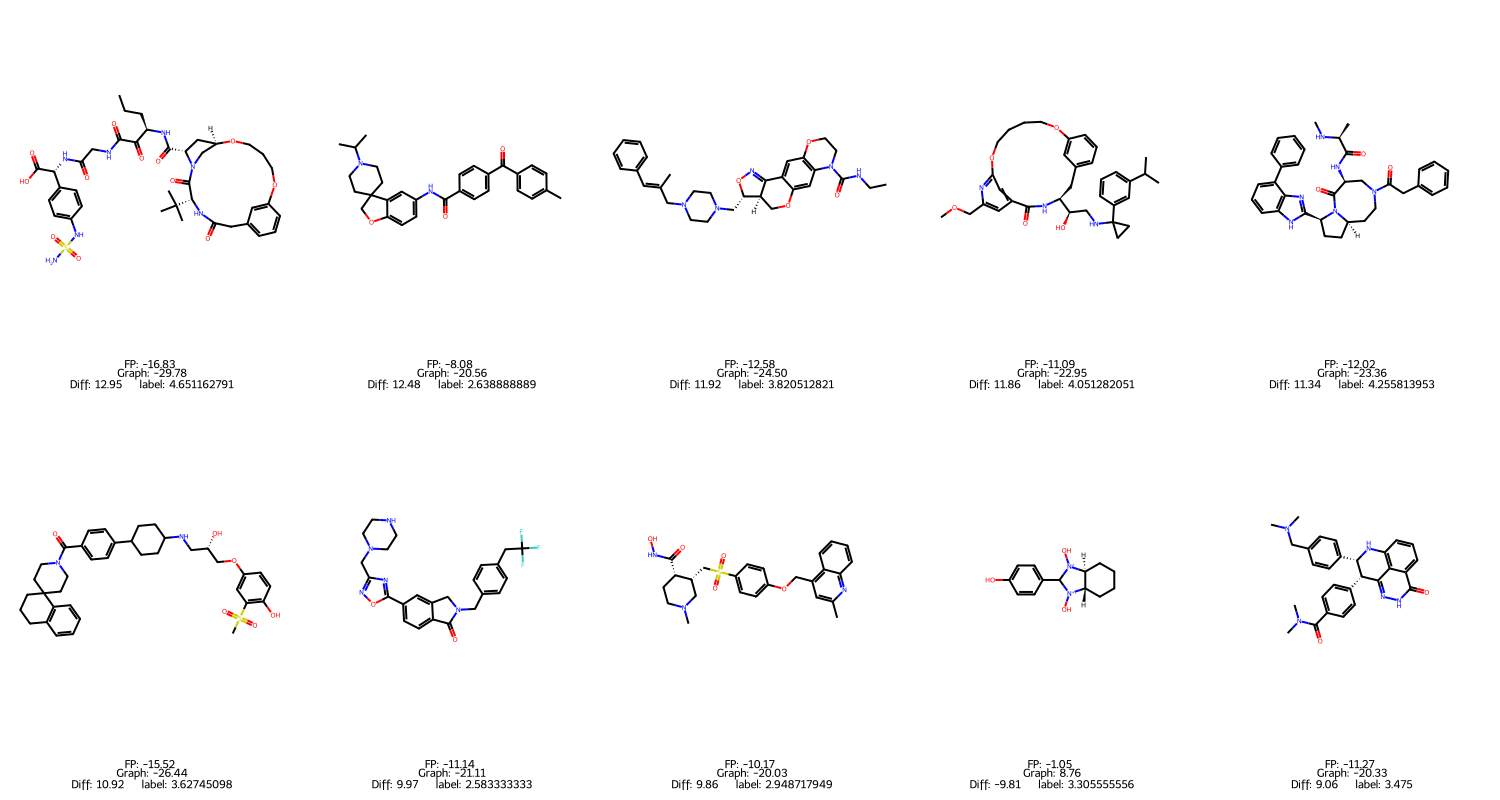

In [206]:
# show top 10
top_smi = df_combo[smi_col].head(10).tolist()
top_mols = [Chem.MolFromSmiles(smi) for smi in top_smi]
top_scores_fp = df_combo[f'{score_col}_fp'].head(10).tolist()
top_scores_graph = df_combo[f'{score_col}_graph'].head(10).tolist()
top_diff = df_combo['diff'].head(10).tolist()
top_label = df_combo[extra_label].head(10).tolist()
# create legend texts for every mol by zipping the scores together
legends = [f'FP: {fp:.2f}\n Graph: {graph:.2f}\n Diff: {diff:.2f} \t label: {label}' for fp, graph, diff, label in zip(top_scores_fp, top_scores_graph, top_diff, top_label)]
Chem.Draw.MolsToGridImage(top_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

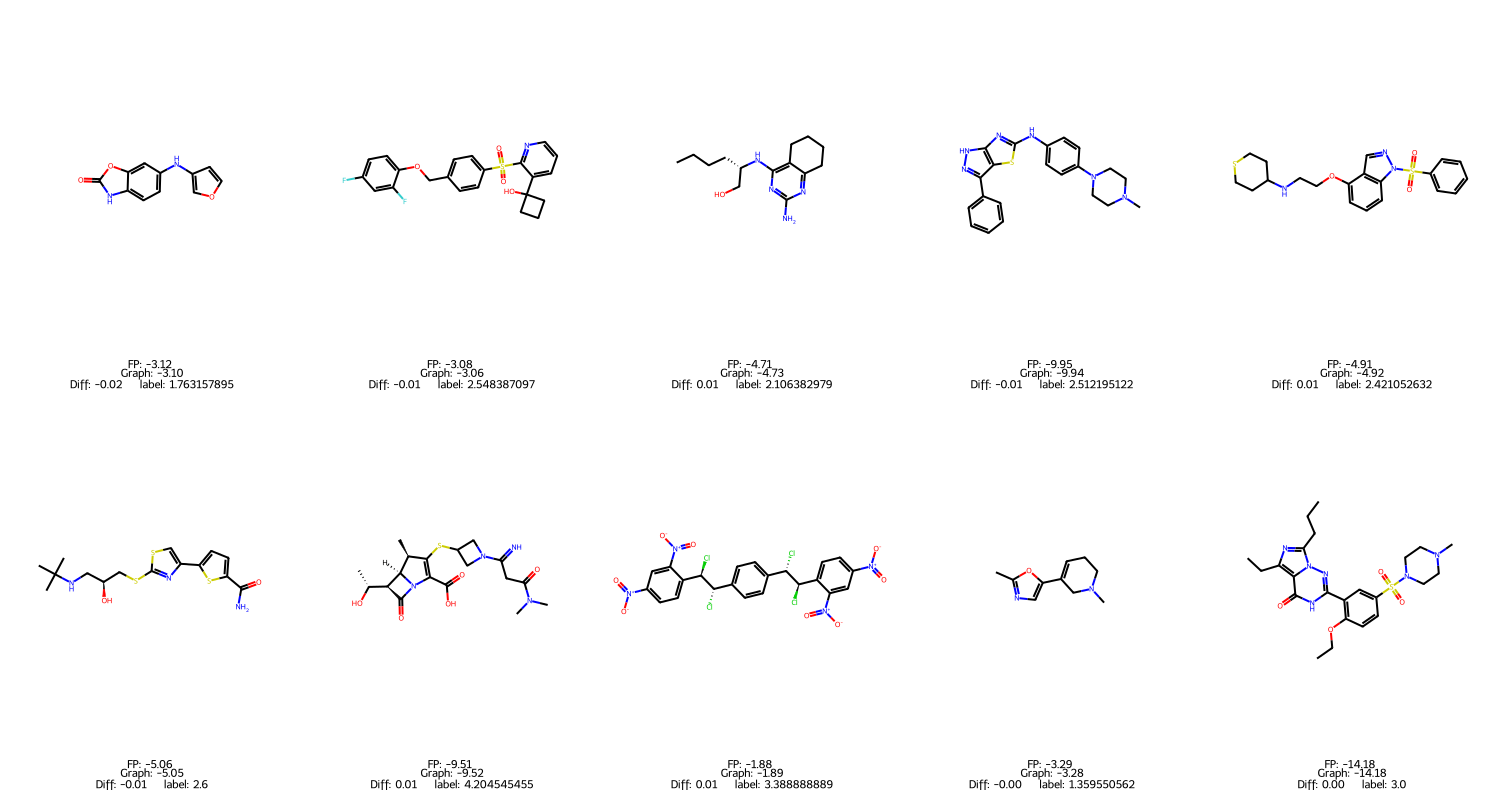

In [207]:
# show bottom 10
bottom_smi = df_combo[smi_col].tail(10).tolist()
bottom_mols = [Chem.MolFromSmiles(smi) for smi in bottom_smi]
bottom_scores_fp = df_combo[f'{score_col}_fp'].tail(10).tolist()
bottom_scores_graph = df_combo[f'{score_col}_graph'].tail(10).tolist()
bottom_diff = df_combo['diff'].tail(10).tolist()
bottom_label = df_combo[extra_label].tail(10).tolist()
# create legend texts for every mol by zipping the scores together
legends = [f'FP: {fp:.2f}\n Graph: {graph:.2f}\n Diff: {diff:.2f} \t label: {label}' for fp, graph, diff, label in zip(bottom_scores_fp, bottom_scores_graph, bottom_diff, bottom_label)]
Chem.Draw.MolsToGridImage(bottom_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

### Distribution of values

In [199]:
len(df_fp)

1681

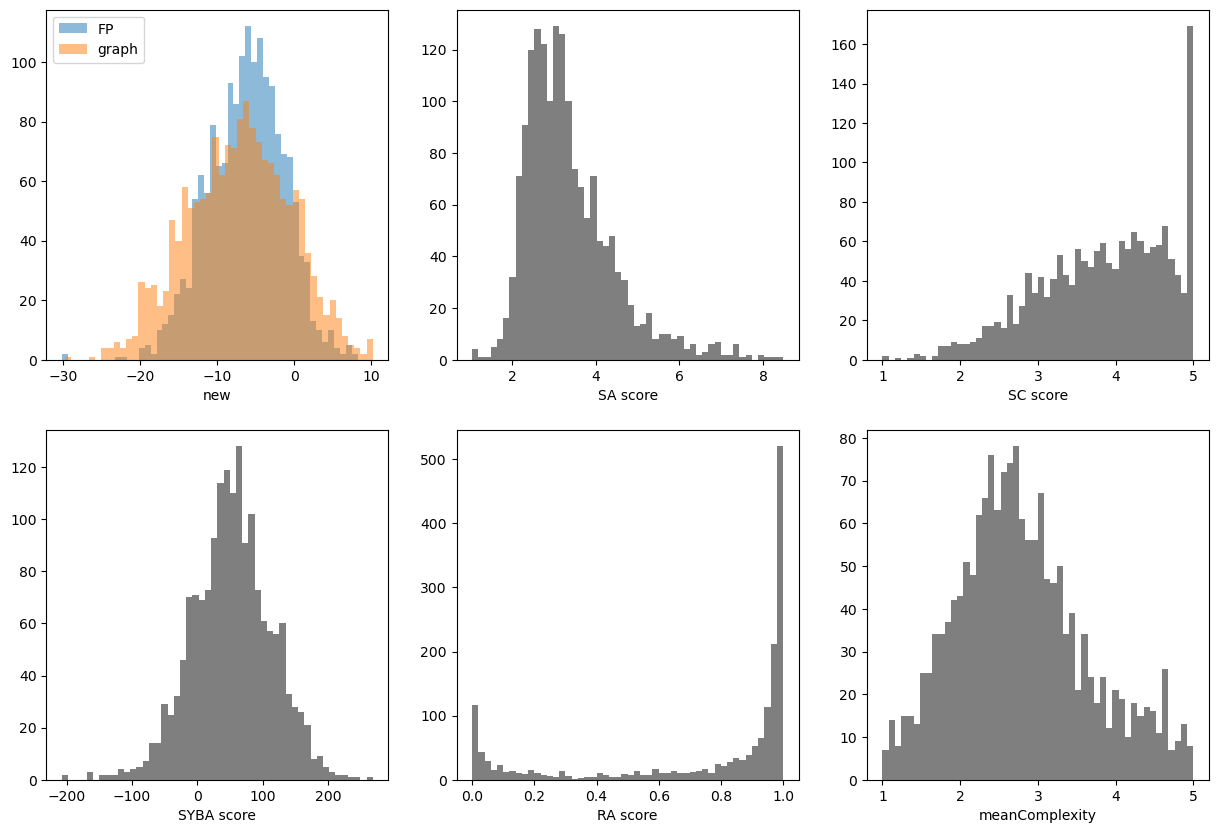

In [201]:
# plot histograms
fig, axs = plt.subplots(2,3,figsize=(15, 10))

bins = 50
alpha = 0.5
density=False
axs[0,0].hist(df_fp[score_col], bins=bins, alpha=alpha, label='FP',density=density)
axs[0,0].set_xlabel('new');
axs[0,0].hist(df_graph[score_col], bins=bins, alpha=alpha, label='graph', density=density)
axs[0,0].legend(loc='upper left');
axs[0,1].hist(df_graph['SA_score'], bins=bins, alpha=alpha, density=density, color='k')
axs[0,1].set_xlabel('SA score');
axs[0,2].hist(df_graph['SC_score'], bins=bins, alpha=alpha, density=density, color='k')
axs[0,2].set_xlabel('SC score');
axs[1,0].hist(df_graph['SYBA_score'], bins=bins, alpha=alpha, density=density, color='k')
axs[1,0].set_xlabel('SYBA score');
axs[1,1].hist(df_graph['RAscore'], bins=bins, alpha=alpha, density=density, color='k')
axs[1,1].set_xlabel('RA score');
if testset == 'sheridan':
    axs[1,2].hist(df_graph['meanComplexity'], bins=bins, alpha=alpha, density=density, color='k')
    axs[1,2].set_xlabel('meanComplexity');

### Classification power on hard/easy to synthesize compounds
Based on test sets from SYBA classified into ES (easy to synthesis) and HS (hard to synthesis) compounds.
Two sources are included: MC (labelled by medicinal chemists) and CP (classified by complexity scores).

In [159]:
# HS gets label 0, ES gets label 1 based on column label
df_fp['label_bin'] = df_fp['label'].apply(lambda x: 0 if x == 'HS' else 1)
df_graph['label_bin'] = df_graph['label'].apply(lambda x: 0 if x == 'HS' else 1)

In [160]:
# calculate ROC AUC, acc, SN and SP
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

roc_curve_fp = roc_curve(df_fp['label_bin'], df_fp[score_col])
roc_curve_graph = roc_curve(df_graph['label_bin'], df_graph[score_col])
roc_curve_sa = roc_curve(df_fp['label_bin'], df_fp['SA_score'], pos_label=0)
roc_curve_sc = roc_curve(df_fp['label_bin'], df_fp['SC_score'], pos_label=0)
roc_curve_syba = roc_curve(df_fp['label_bin'], df_fp['SYBA_score'])
roc_curve_ra = roc_curve(df_fp['label_bin'], df_fp['RAscore'])
auc_fp = auc(roc_curve_fp[0], roc_curve_fp[1])
auc_graph = auc(roc_curve_graph[0], roc_curve_graph[1])
auc_sa = auc(roc_curve_sa[0], roc_curve_sa[1])
auc_sc = auc(roc_curve_sc[0], roc_curve_sc[1])
auc_syba = auc(roc_curve_syba[0], roc_curve_syba[1])
auc_ra = auc(roc_curve_ra[0], roc_curve_ra[1])


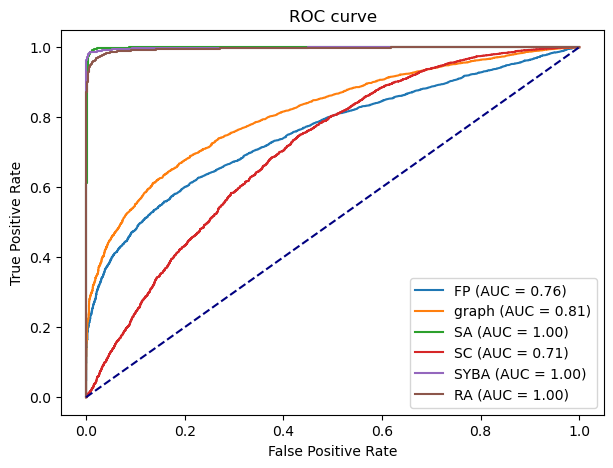

In [161]:
# plot ROC curve
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(roc_curve_fp[0], roc_curve_fp[1], label=f'FP (AUC = {auc_fp:.2f})')
ax.plot(roc_curve_graph[0], roc_curve_graph[1], label= f'graph (AUC = {auc_graph:.2f})')
ax.plot(roc_curve_sa[0], roc_curve_sa[1], label=f'SA (AUC = {auc_sa:.2f})')
ax.plot(roc_curve_sc[0], roc_curve_sc[1], label=f'SC (AUC = {auc_sc:.2f})')
ax.plot(roc_curve_syba[0], roc_curve_syba[1], label=f'SYBA (AUC = {auc_syba:.2f})')
ax.plot(roc_curve_ra[0], roc_curve_ra[1], label=f'RA (AUC = {auc_ra:.2f})')
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
ax.legend(loc="lower right");


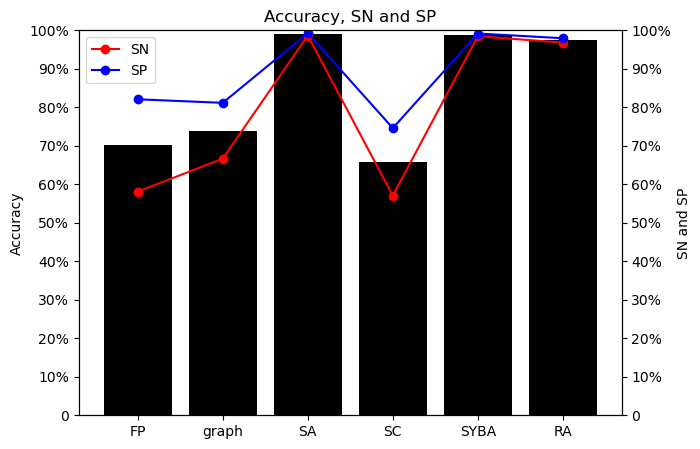

In [162]:
# calculate accuracy, SN and SP
# get splitting score by balancing SN and SP (youden index = max(SN + SP - 1))
import numpy as np
def get_splitting_score(y_true, y_pred, pos_label=1):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=pos_label)
    # calculate youden index
    youden = tpr - fpr
    # locate the index
    idx = np.argmax(youden)
    return thresholds[idx]

def get_acc_sn_sp(y_true, y_pred, threshold, bigger = True):
    if bigger:
        y_pred_bin = np.where(y_pred > threshold, 1, 0)
    else:
        y_pred_bin = np.where(y_pred < threshold, 1, 0)
    acc = accuracy_score(y_true, y_pred_bin)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    sn = tp / (tp + fn)
    sp = tn / (tn + fp)
    return acc, sn, sp

threshold_fp = get_splitting_score(df_fp['label_bin'], df_fp[score_col])
threshold_graph = get_splitting_score(df_graph['label_bin'], df_graph[score_col])
threshold_sa = get_splitting_score(df_fp['label_bin'], df_fp['SA_score'], pos_label=0)
threshold_sc = get_splitting_score(df_fp['label_bin'], df_fp['SC_score'], pos_label=0)   
threshold_syba = get_splitting_score(df_fp['label_bin'], df_fp['SYBA_score'])
threshold_ra = get_splitting_score(df_fp['label_bin'], df_fp['RAscore'])

acc_fp, sn_fp, sp_fp = get_acc_sn_sp(df_fp['label_bin'], df_fp[score_col], threshold_fp)
acc_graph, sn_graph, sp_graph = get_acc_sn_sp(df_graph['label_bin'], df_graph[score_col], threshold_graph)
acc_sa, sn_sa, sp_sa = get_acc_sn_sp(df_fp['label_bin'], df_fp['SA_score'], threshold_sa, bigger=False)
acc_sc, sn_sc, sp_sc = get_acc_sn_sp(df_fp['label_bin'], df_fp['SC_score'], threshold_sc, bigger=False)
acc_syba, sn_syba, sp_syba = get_acc_sn_sp(df_fp['label_bin'], df_fp['SYBA_score'], threshold_syba)
acc_ra, sn_ra, sp_ra = get_acc_sn_sp(df_fp['label_bin'], df_fp['RAscore'], threshold_ra)

# plot accuracy, SN and SP
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar([0, 1, 2, 3, 4, 5], [acc_fp, acc_graph, acc_sa, acc_sc, acc_syba, acc_ra], color='k')
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['FP', 'graph', 'SA', 'SC', 'SYBA', 'RA'])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy, SN and SP')
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels(['0', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
ax2 = ax.twinx()
ax2.plot([0, 1, 2, 3, 4, 5], [sn_fp, sn_graph, sn_sa, sn_sc, sn_syba, sn_ra], color='r', marker='o', label='SN')
ax2.plot([0, 1, 2, 3, 4, 5], [sp_fp, sp_graph, sp_sa, sp_sc, sp_syba, sp_ra], color='b', marker='o', label='SP')
ax2.set_ylim(0, 1)
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_yticklabels(['0', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
ax2.set_ylabel('SN and SP')
ax2.legend(loc='upper left');


#### Analyse SYBA test set mols

In [37]:
df_fp.head()

idx                                                smi  \
40       SAScore_120  CCCC(NC(=O)C1CC2CN1C(=O)C(C(C)(C)C)NC(=O)Cc3cc...   
36  ZINC000263583624  CC[C@H](C)[C@H](NC(=O)CNC(=O)CNC(=O)[C@@H](NC(...   
54       SAScore_134  CCC5OC(=O)C(C)C(=O)C(C)C(OC1OC(C)CC(N(C)C)C1O)...   
44       SAScore_124  CC(C)CC(NC(=O)C(CC(=O)NC2OC(CO)C(OC1OC(CO)C(O)...   
53       SAScore_133  CCCC5OC(=O)C(C)C(=O)C(C)C(OC1OC(C)CC(N(C)C)C1O...   

    atoms source label  SA_score  SC_score  SYBA_score    logP       QED  \
40     58     MC    HS  6.391644  4.999992  -87.802928  0.0563  0.132072   
36     60     MC    ES  5.406006  4.987230  131.412560 -2.3864  0.041283   
54     60     MC    HS  6.246192  4.978655  -35.877371  5.1030  0.181784   
44     60     MC    HS  5.302448  4.923296  112.383874 -5.9152  0.061614   
53     60     MC    HS  6.917683  4.762753  -50.351775  6.1063  0.216861   

         MW  numheavyatoms   RAscore  smi_score  label_bin  
40  829.930             58  0.074533     -23.00          0  
36  860.988             60  0.124254     -18.92          1  
54  830.976             60  0.012707     -16.62          0  
44  855.896             60  0.119759     -15.22          0  
53  835.052             60  0.010241     -15.20          0

In [39]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df_fp, smilesCol='smi', molCol='mol')

In [40]:
# group by label and source
df_ES = df_fp[df_fp['label'] == 'ES']
df_MC_ES = df_ES[df_ES['source'] == 'MC']
df_CP_ES = df_ES[df_ES['source'] == 'CP']
df_HS = df_fp[df_fp['label'] == 'HS']
df_MC_HS = df_HS[df_HS['source'] == 'MC']
df_CP_HS = df_HS[df_HS['source'] == 'CP']

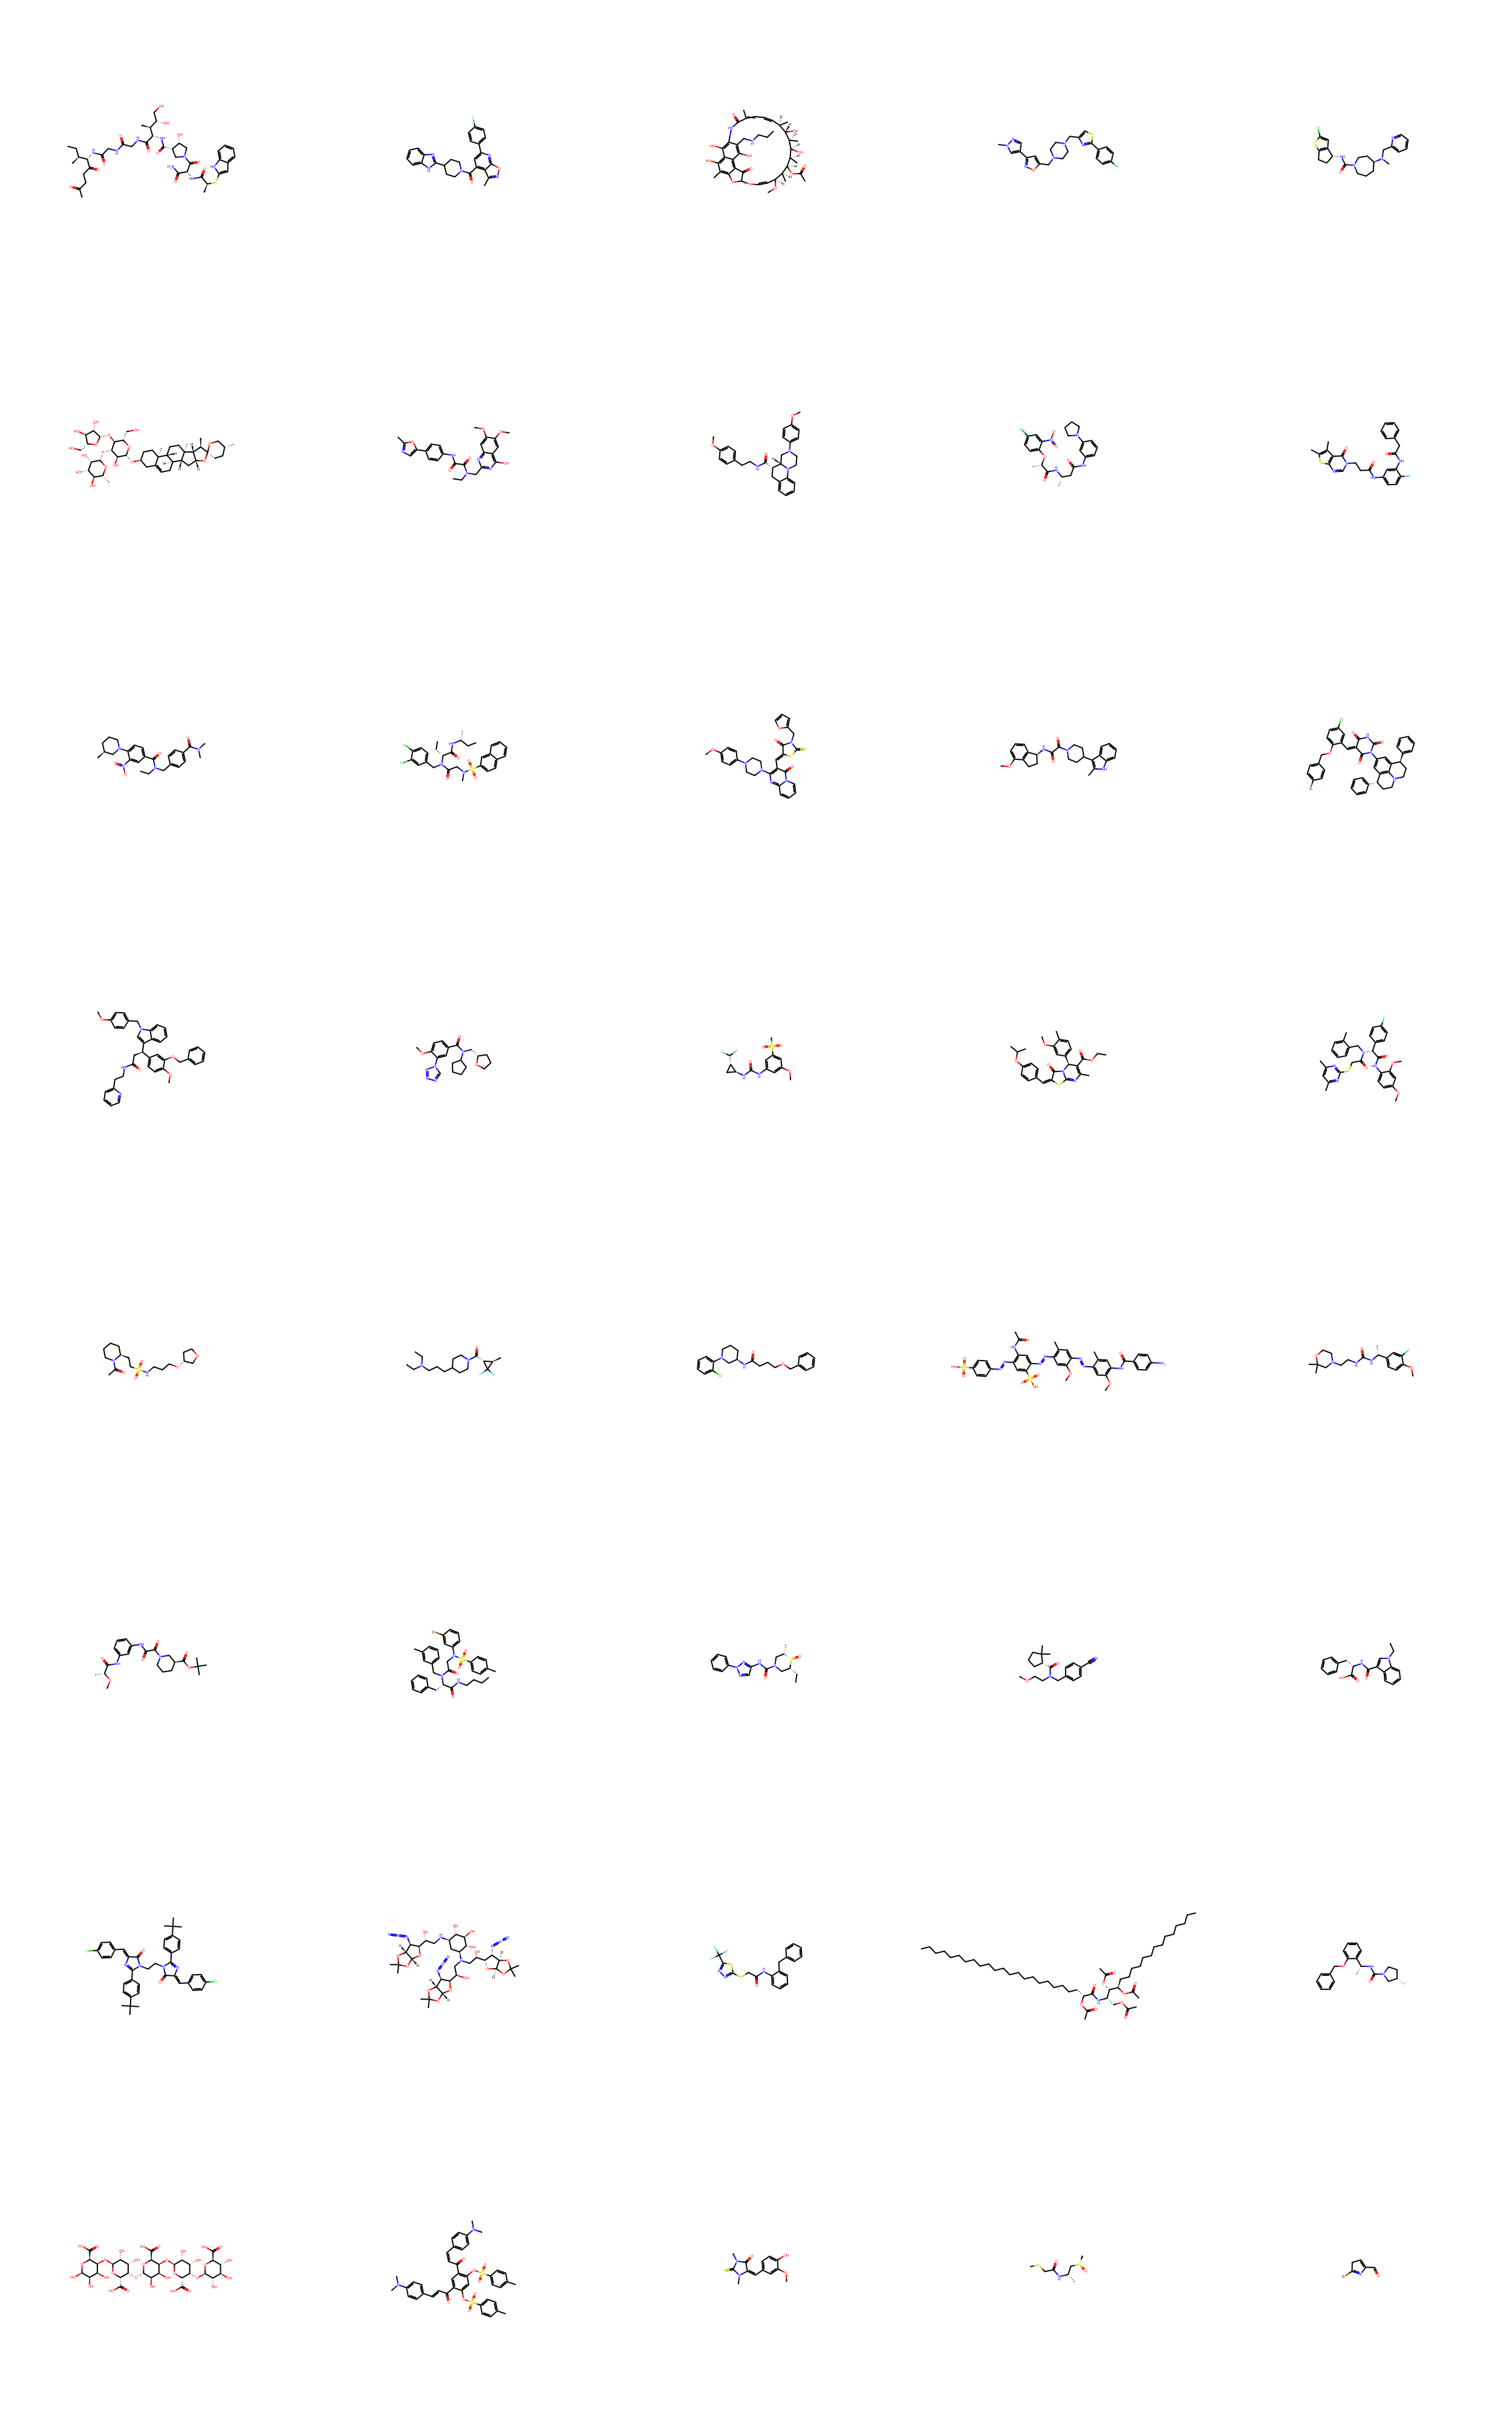

In [41]:
# visualize molecules
Chem.Draw.MolsToGridImage(df_MC_ES['mol'], molsPerRow=5, subImgSize=(500, 500))

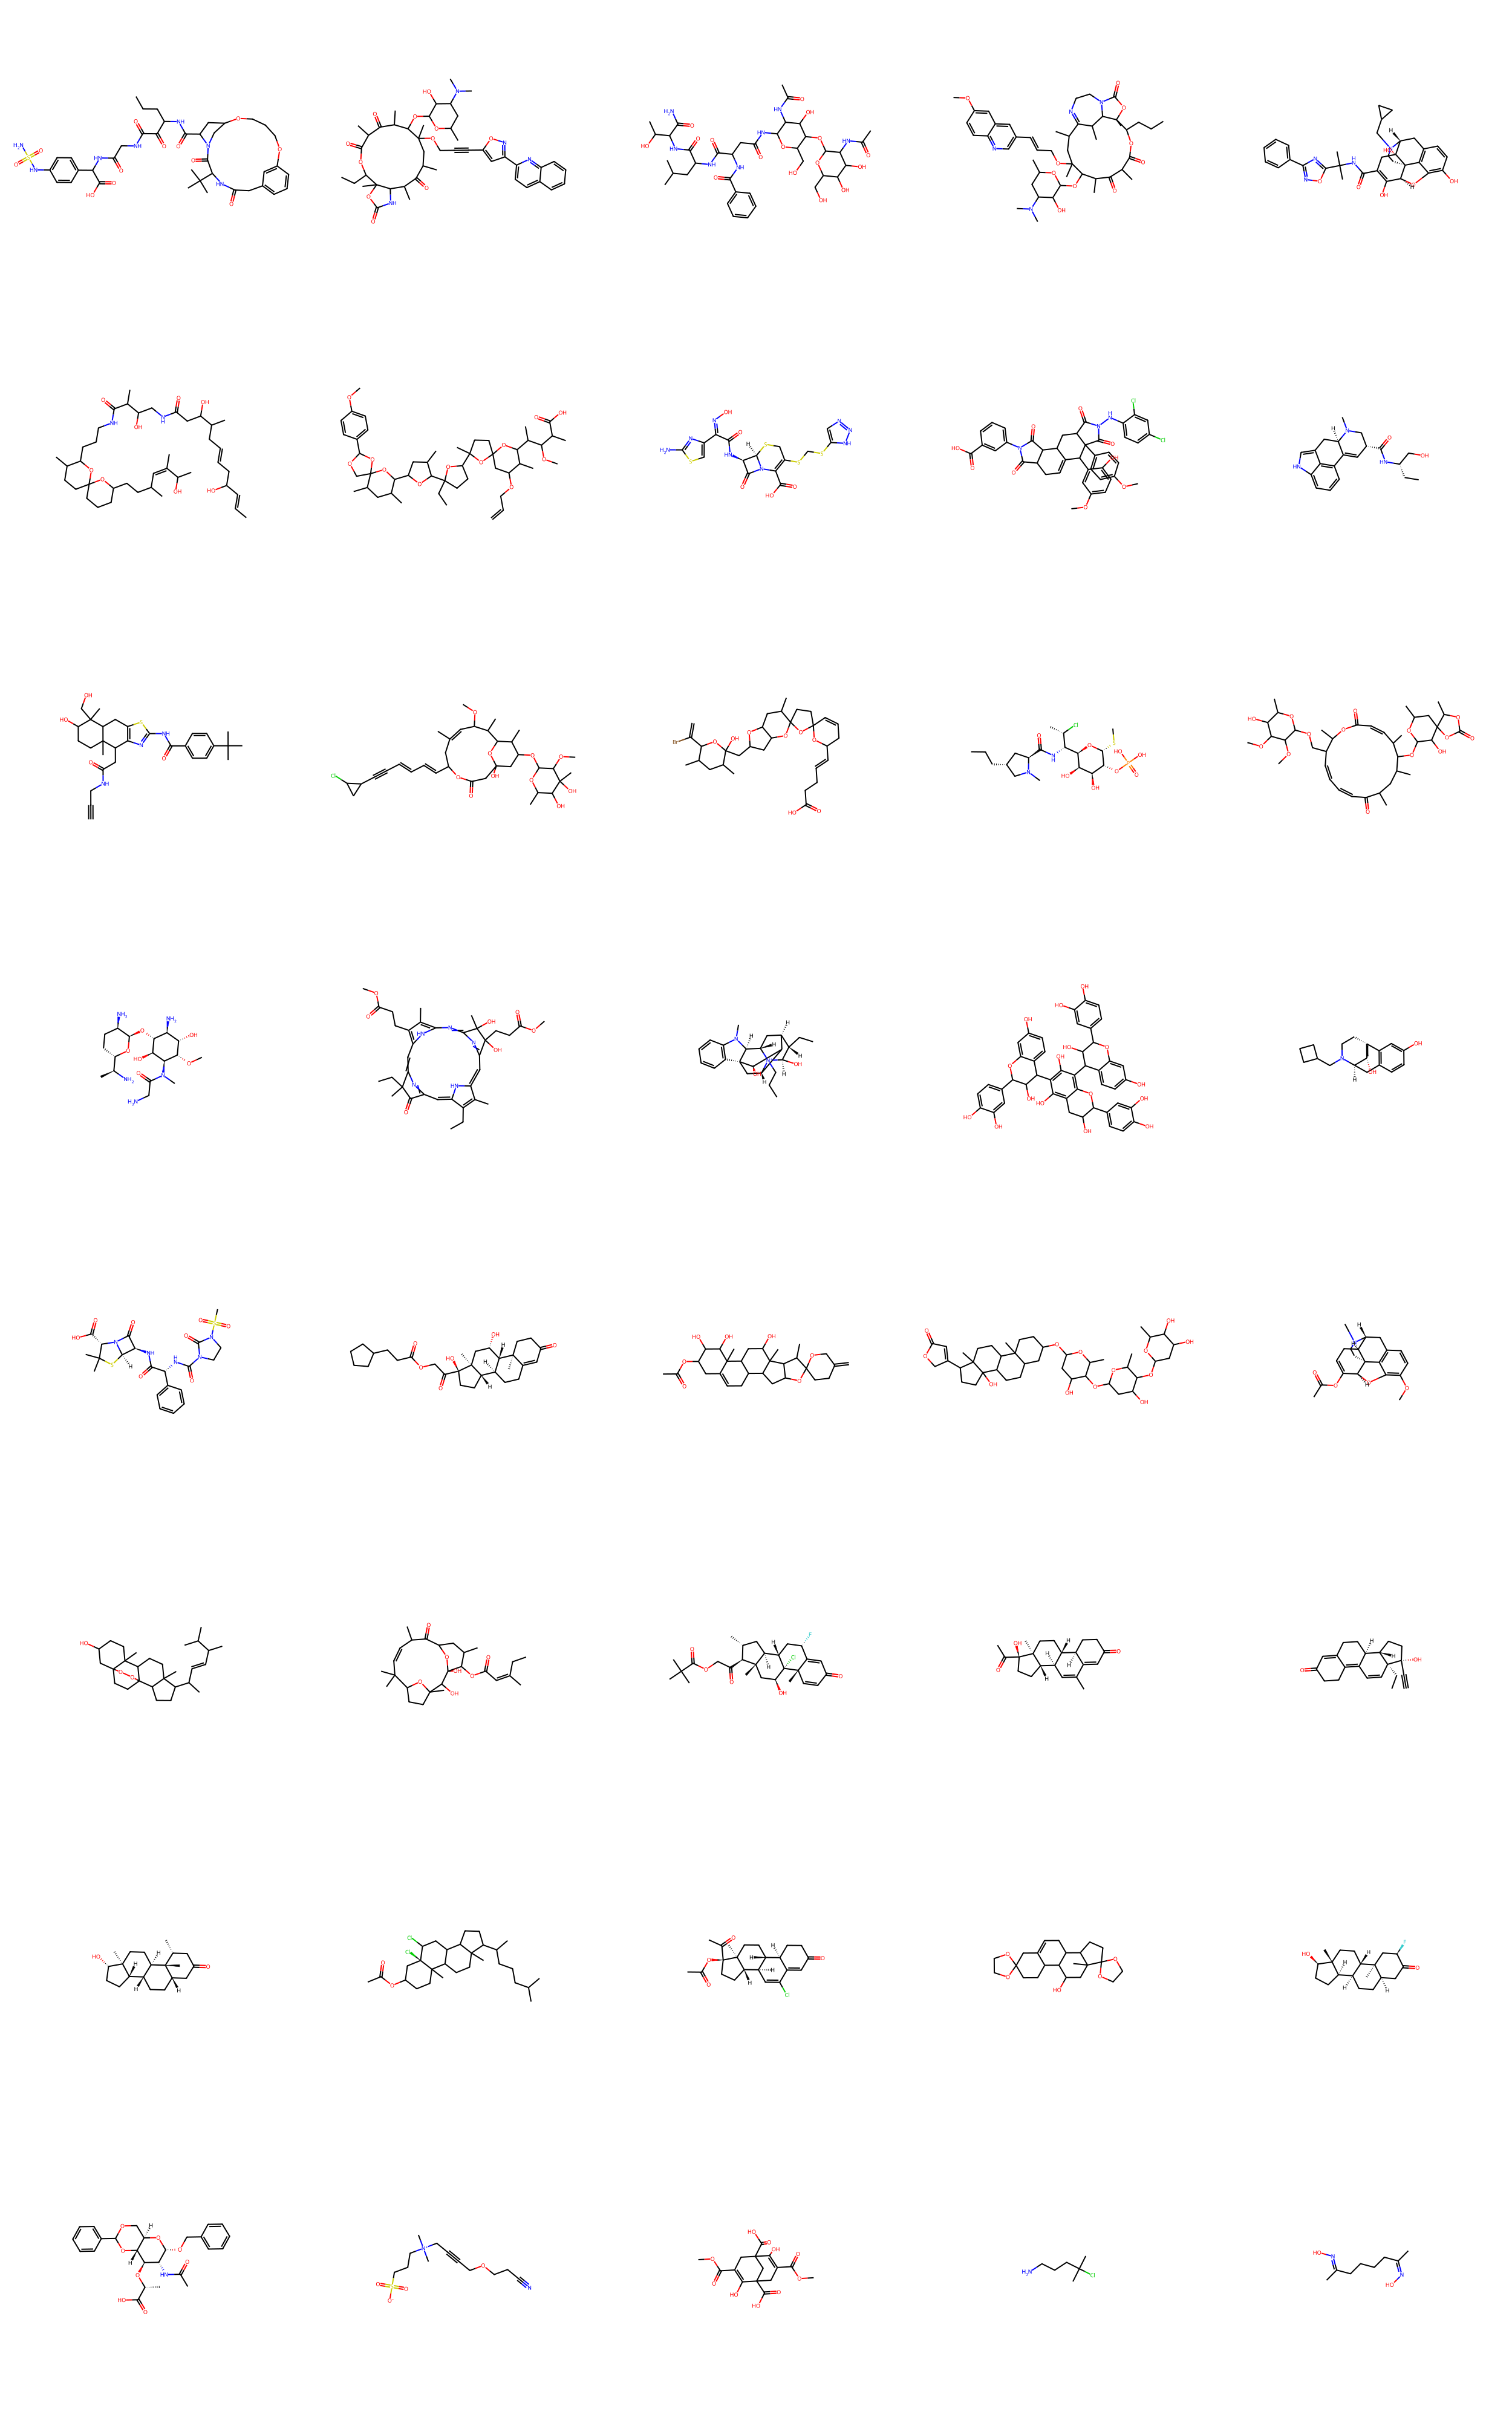

In [42]:
Chem.Draw.MolsToGridImage(df_MC_HS['mol'], molsPerRow=5, subImgSize=(500, 500))

/home/rebecca/miniconda3/envs/intuitive-sc/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


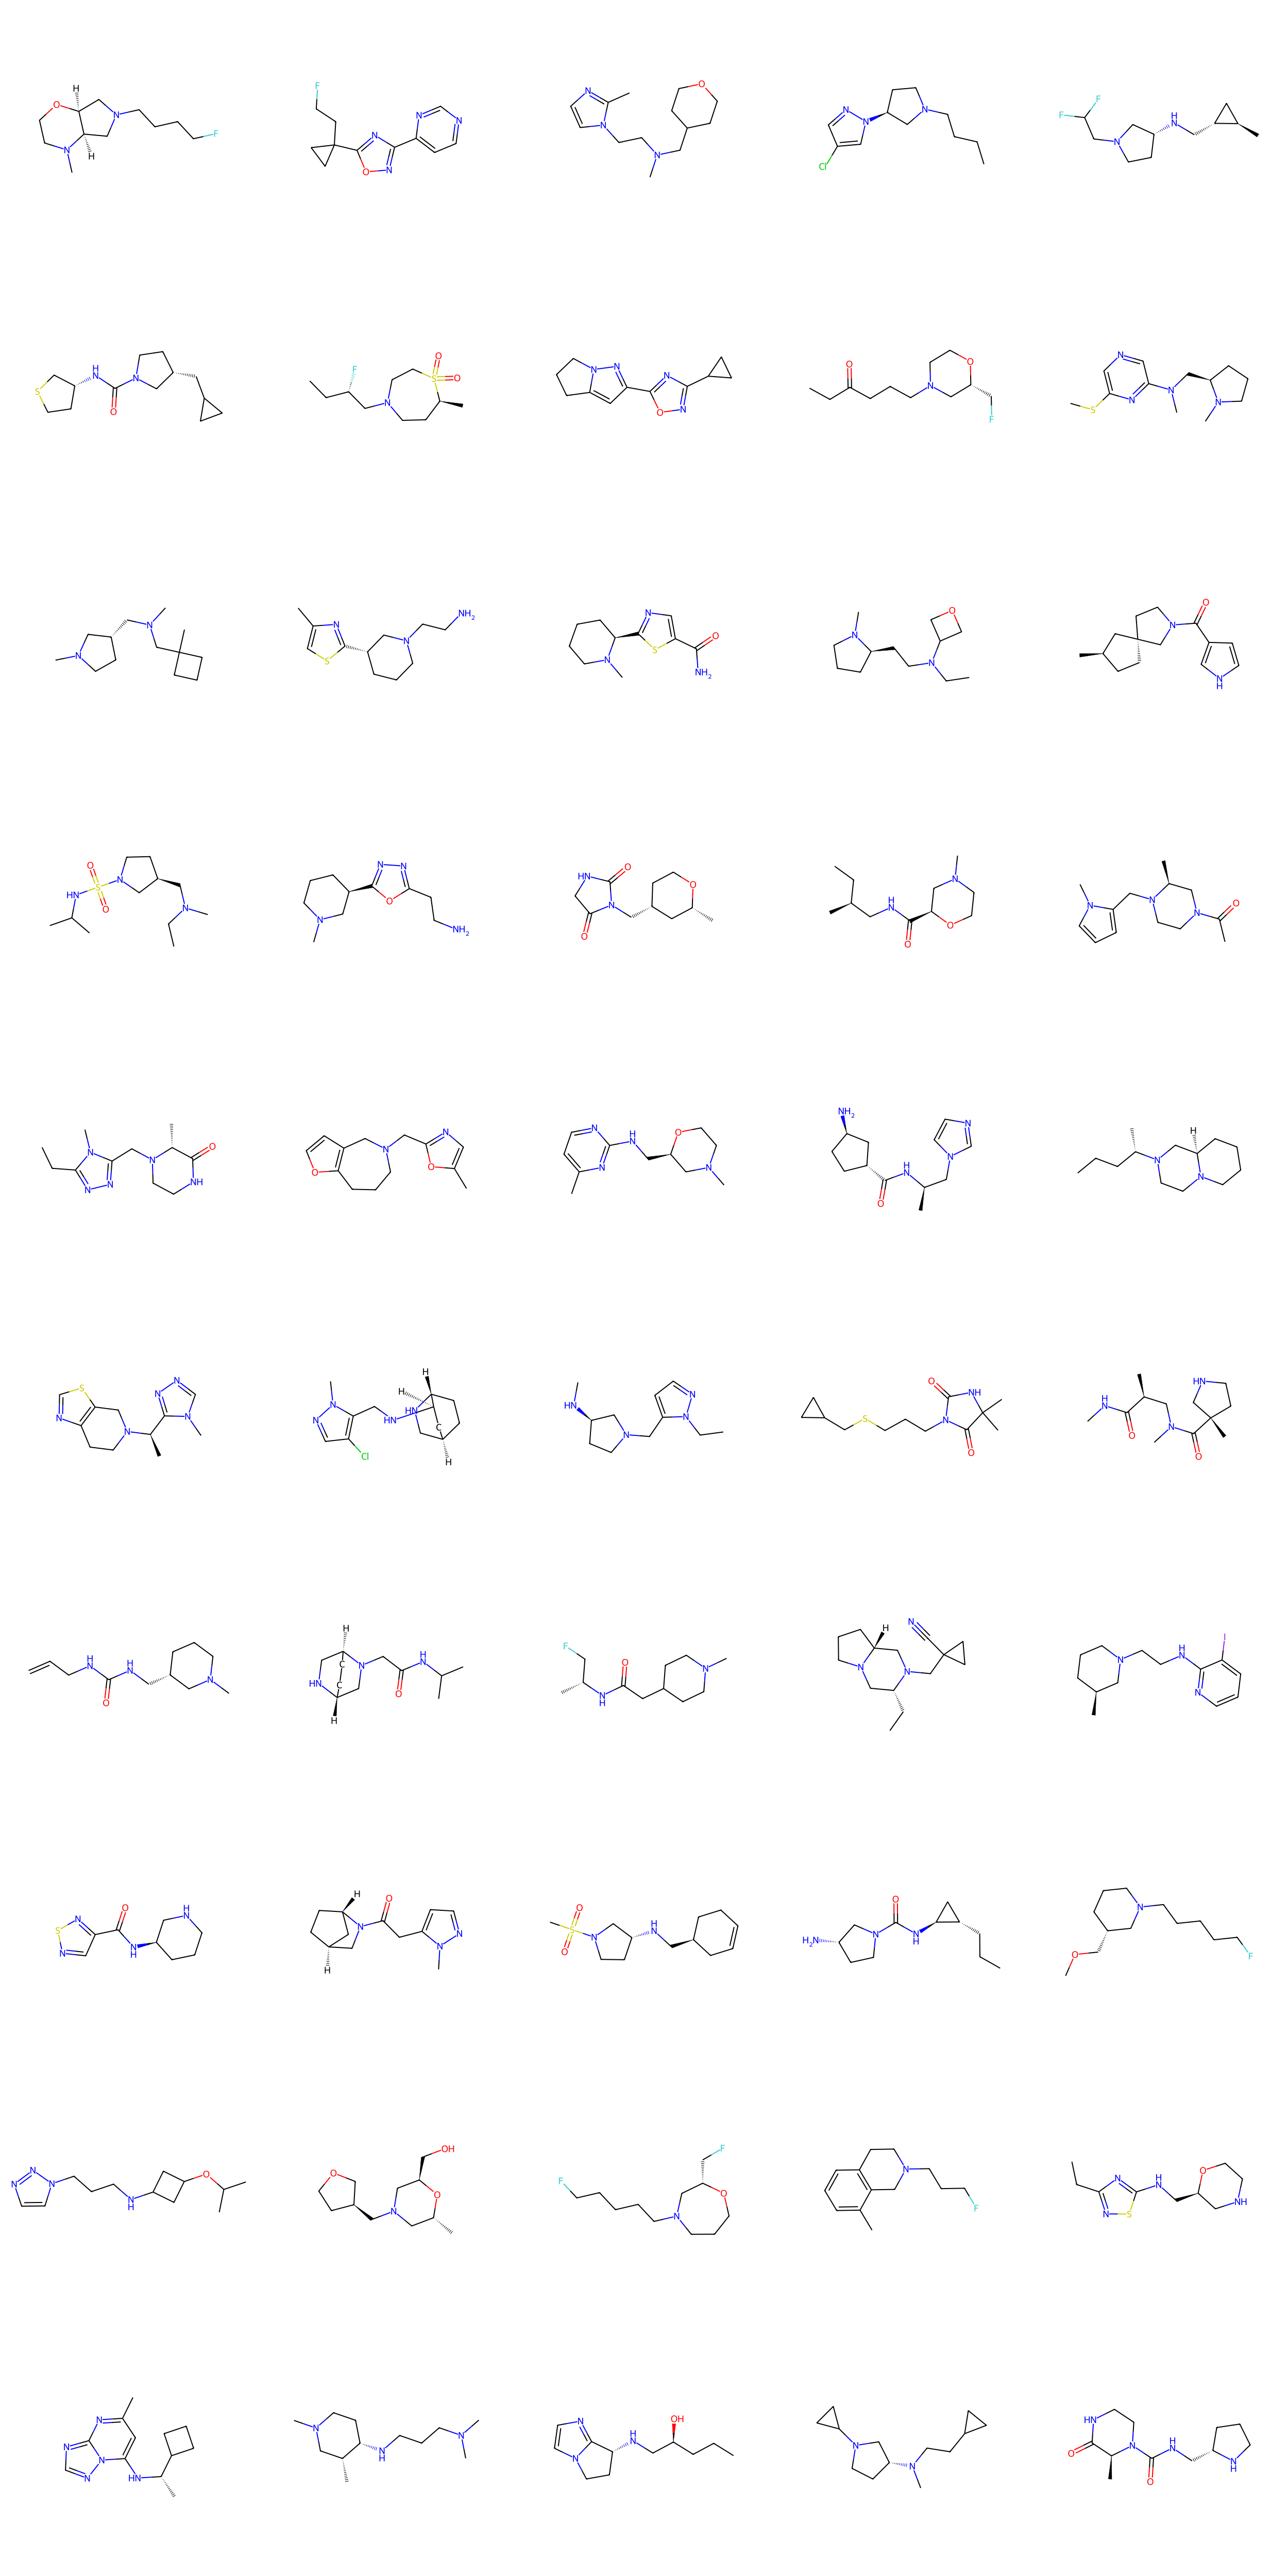

In [43]:
Chem.Draw.MolsToGridImage(df_CP_ES['mol'], molsPerRow=5, subImgSize=(500, 500))

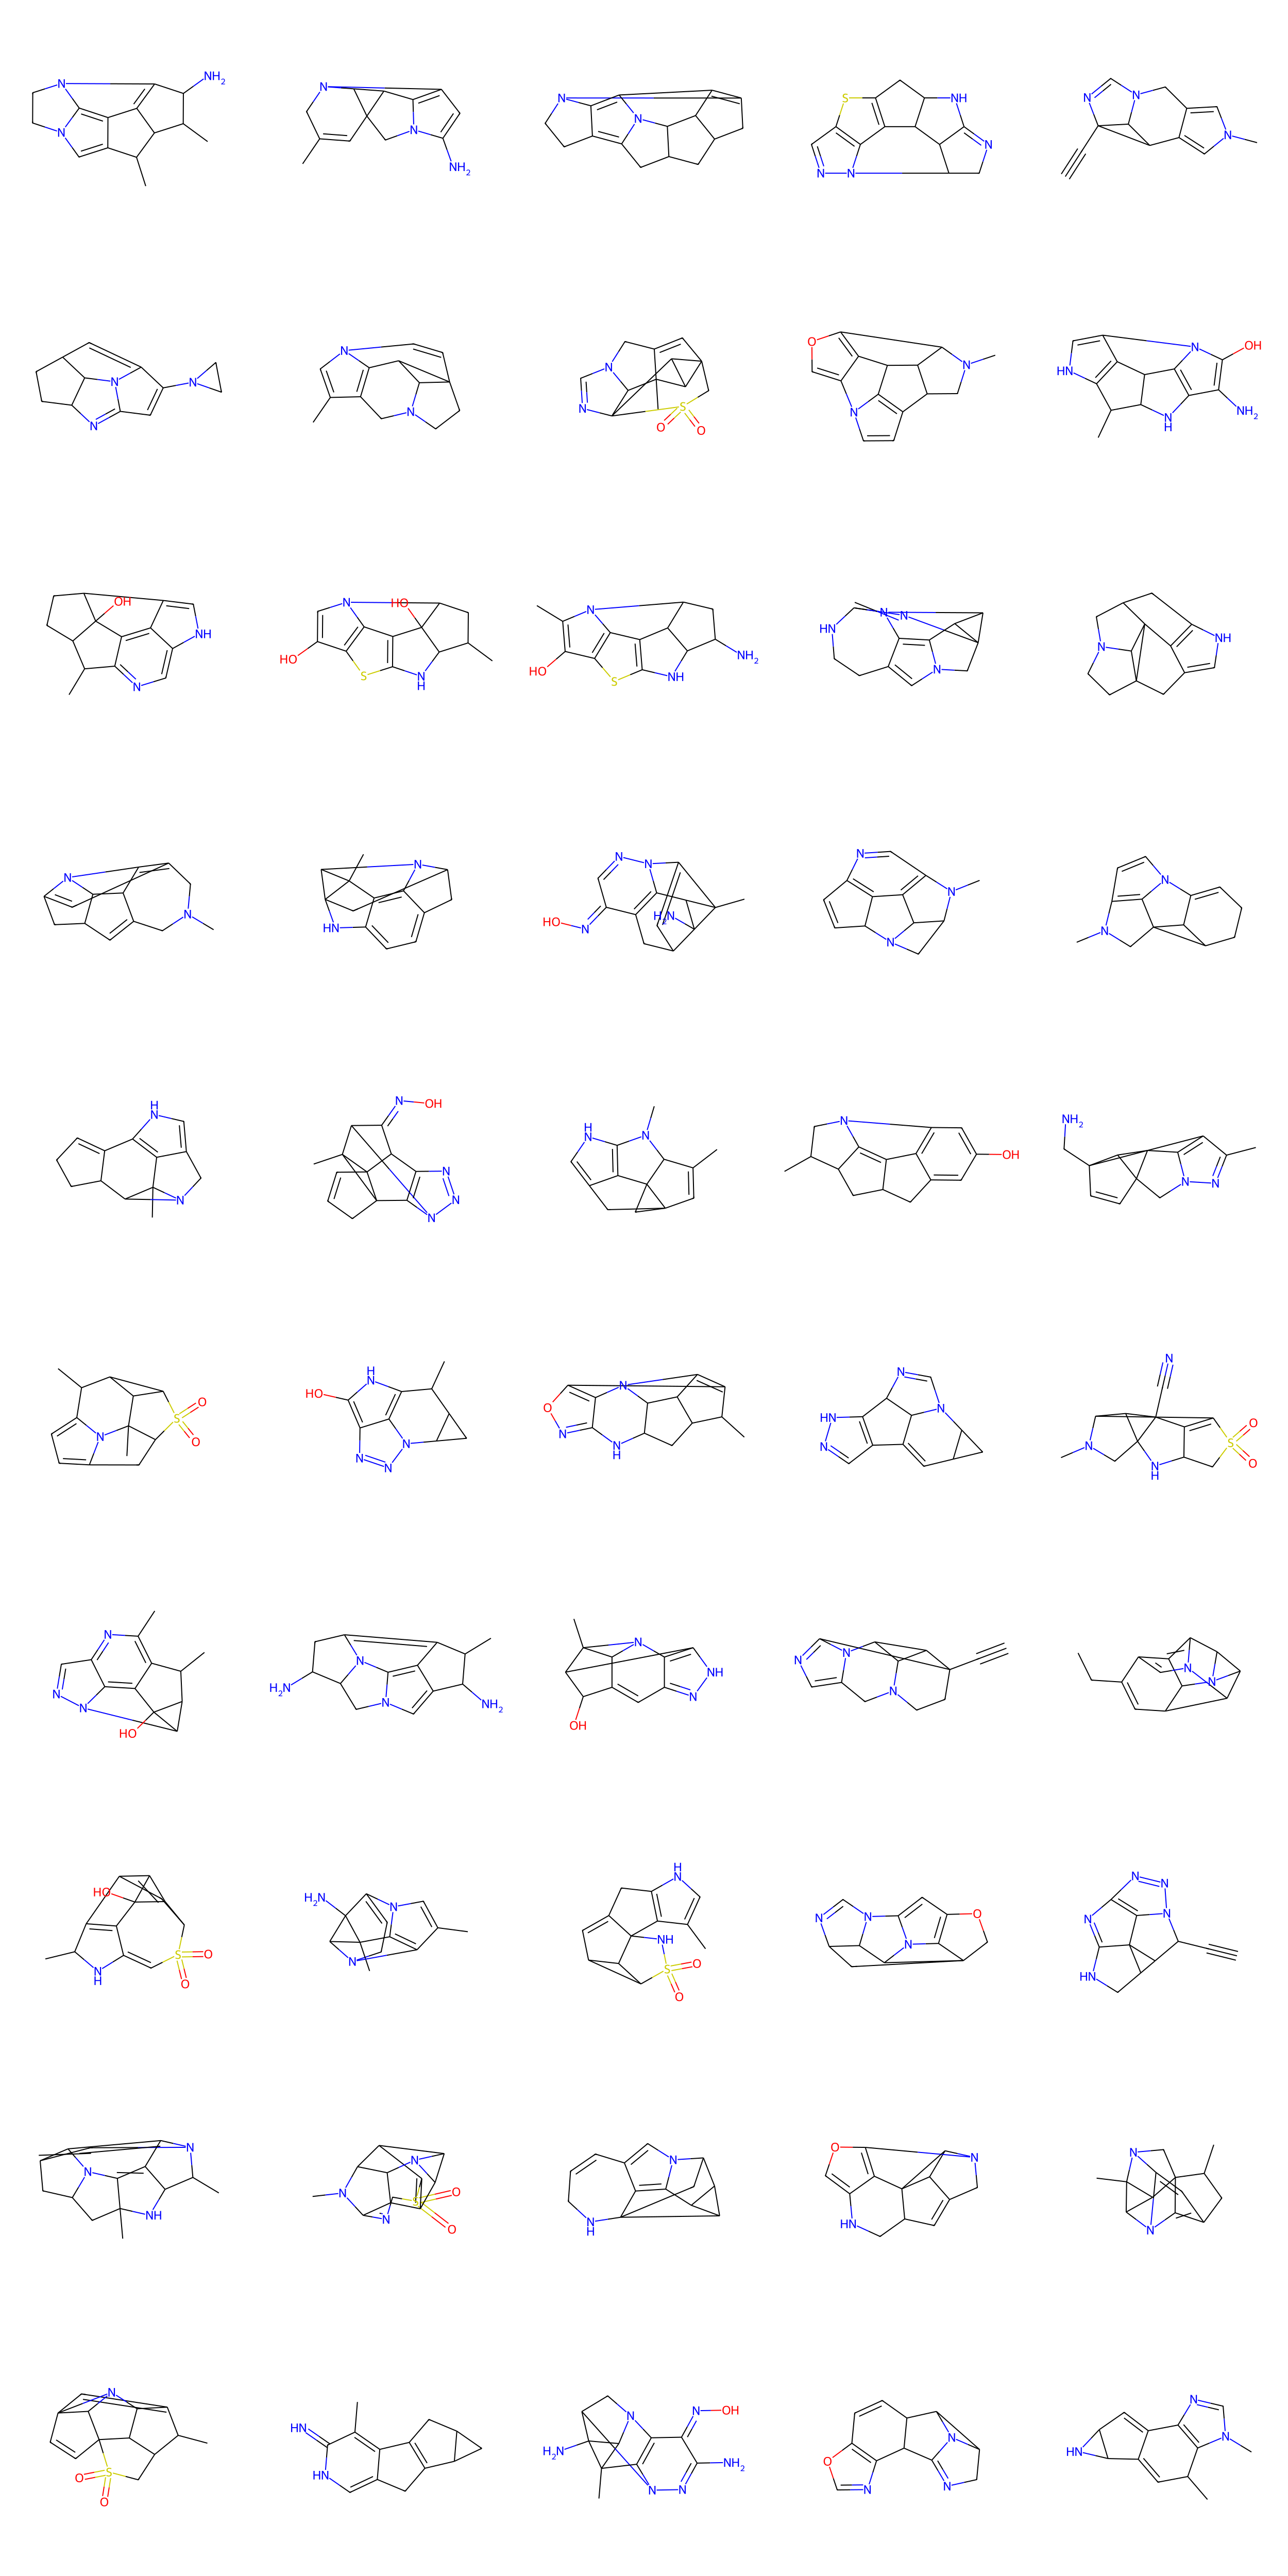

In [44]:
Chem.Draw.MolsToGridImage(df_CP_HS['mol'], molsPerRow=5, subImgSize=(500, 500))